In [ ]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, average_precision_score,
                             matthews_corrcoef, confusion_matrix,
                             classification_report)
from tensorflow.keras import layers, Input, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split

#Required functions

In [ ]:
def evaluate_model(y_true, y_pred, y_pred_proba):
    metrics = {}

    metrics['ROC AUC'] = roc_auc_score(y_true, y_pred_proba)
    metrics['AUC 0.1'] = roc_auc_score(y_true, y_pred_proba, max_fpr=0.1)
    metrics['AUPR'] = average_precision_score(y_true, y_pred_proba)
    metrics['MCC'] = matthews_corrcoef(y_true, y_pred)
    metrics['Accuracy'] = accuracy_score(y_true, y_pred)
    metrics['Recall'] = recall_score(y_true, y_pred)
    metrics['Precision'] = precision_score(y_true, y_pred)
    metrics['F1 Score'] = f1_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    metrics['specificity'] = tn / (tn + fp)

    metrics['confusion_matrix'] = confusion_matrix(y_true, y_pred)
    metrics['classification_report'] = classification_report(y_true, y_pred, output_dict=True)

    return metrics

In [ ]:
def print_metrics(metrics):
    print(f"ROC AUC: {metrics['ROC AUC']:.4f}")
    print(f"AUC 0.1: {metrics['AUC 0.1']:.4f}")
    print(f"AUPR: {metrics['AUPR']:.4f}")
    print(f"MCC: {metrics['MCC']:.4f}")
    print(f"Accuracy: {metrics['Accuracy']:.4f}")
    print(f"Recall (Sensitivity): {metrics['Recall']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"F1 Score: {metrics['F1 Score']:.4f}")
    print(f"Specificity: {metrics['specificity']:.4f}")
    print("\nConfusion Matrix:")
    print(metrics['confusion_matrix'])
    print("\nClassification Report:")
    print(pd.DataFrame(metrics['classification_report']).transpose())

In [ ]:
def plot_metric_across_folds(metric_list, title, ylabel):
    plt.figure(figsize=(10, 5))
    for i, values in enumerate(metric_list, 1):
        plt.plot(values, label=f'Fold {i}')
    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
def plot_all_metrics_together(history, test_callback):
    train_metrics = history.history
    test_metrics = test_callback.epoch_metrics if hasattr(test_callback, 'epoch_metrics') else {}
    base_metrics = [m for m in train_metrics.keys() if not m.startswith('val_')]

    for metric in base_metrics:
        plt.figure()

        if metric in train_metrics:
            plt.plot(train_metrics[metric], label='Train')

        val_key = 'val_' + metric
        if val_key in train_metrics:
            plt.plot(train_metrics[val_key], label='Validation')

        plt.title(f'{metric.capitalize()}')
        plt.xlabel('Epoch')
        plt.ylabel(metric.capitalize())
        plt.legend()
        plt.grid(True)
        plt.show()


from tensorflow.keras.callbacks import Callback

class TestEvaluationCallback(Callback):
    def __init__(self, test_data):
        super(TestEvaluationCallback, self).__init__()
        self.test_data = test_data
        self.epoch_metrics = {}

    def on_epoch_end(self, epoch, logs=None):
        x_test, y_test = self.test_data
        results = self.model.evaluate(x_test, y_test, verbose=0, return_dict=True)
        for key, value in results.items():
            if key not in self.epoch_metrics:
                self.epoch_metrics[key] = []
            self.epoch_metrics[key].append(value)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#5-Fold evaluations

In [ ]:
save_dir = '/content/drive/MyDrive/PhD/SiaScoreNet/5 Fold/'

##ESM	and Concatenation of HLA and peptide embeddings

In [ ]:
metrics = {
    'roc_auc': [],
    'aupr': [],
    'mcc': [],
    'accuracy': [],
    'recall': [],
    'precision': [],
    'f1': [],
    'Specificity':[]
}


def create_model():
    def swish(x):
        return x * tf.nn.sigmoid(x)

    dropout_rate = 0.2
    ac = swish

    input_pep = Input(shape=(320,), name='peptide')
    x_pep = layers.Dense(256, activation=ac)(input_pep)
    x_pep = layers.BatchNormalization()(x_pep)
    x_pep = layers.Dropout(dropout_rate)(x_pep)
    x_pep = layers.Dense(128, activation=ac)(x_pep)
    x_pep = layers.BatchNormalization()(x_pep)
    x_pep = layers.Dropout(dropout_rate)(x_pep)
    x_pep = layers.Dense(64, activation=ac)(x_pep)


    input_hla = Input(shape=(320,), name='hla')
    x_hla = layers.Dense(256, activation=ac)(input_hla)
    x_hla = layers.BatchNormalization()(x_hla)
    x_hla = layers.Dropout(dropout_rate)(x_hla)
    x_hla = layers.Dense(128, activation=ac)(x_hla)
    x_hla = layers.BatchNormalization()(x_hla)
    x_hla = layers.Dropout(dropout_rate)(x_hla)
    x_hla = layers.Dense(64, activation=ac)(x_hla)

    x = layers.Concatenate()([x_pep, x_hla])

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(16, activation=ac)(x)

    x= layers.BatchNormalization()(x)
    x= layers.Dropout(dropout_rate)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    # Build model
    model = Model(inputs=[input_pep, input_hla], outputs=output)

    # Optimizer
    try:
        from tensorflow.keras.optimizers.experimental import AdamW
        optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-4)
    except ImportError:
        from tensorflow.keras.optimizers import Adam
        optimizer = Adam(learning_rate=1e-3)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='AUC'),
                 tf.keras.metrics.Recall(name='Recall'),
                 tf.keras.metrics.Precision(name='Precision'),
                 tf.keras.metrics.AUC(name='AUPR', curve='PR')]
    )

    return model


In [ ]:
all_train_losses = []
all_val_losses = []
all_test_losses = []

all_train_aucs = []
all_val_aucs = []
all_test_aucs = []

for fold in range(1, 6):
    print(f"\nFold {fold}/5")
    train_df = pd.read_csv(f"{save_dir}train_fold_{fold}.csv").drop(columns=['Unnamed: 0'])
    val_df = pd.read_csv(f"{save_dir}val_fold_{fold}.csv").drop(columns=['Unnamed: 0'])
    test_df = pd.read_csv(f"{save_dir}test_fold_{fold}.csv").drop(columns=['Unnamed: 0'])


    X_train = train_df.drop(columns=['label', 'HLA', 'peptide'])
    y_train = train_df['label']
    X_val = val_df.drop(columns=['label', 'HLA', 'peptide'])
    y_val = val_df['label']
    X_test = test_df.drop(columns=['label', 'HLA', 'peptide'])
    y_test = test_df['label']


    inputs_train = {
        'peptide': X_train.iloc[:, 9:329].values,
        'hla': X_train.iloc[:, 329:].values
    }
    inputs_val = {
        'peptide': X_val.iloc[:, 9:329].values,
        'hla': X_val.iloc[:, 329:].values
    }
    inputs_test = {
        'peptide': X_test.iloc[:, 9:329].values,
        'hla': X_test.iloc[:, 329:].values
    }

    test_eval_callback = TestEvaluationCallback((inputs_test, y_test))

    model = create_model()
    history = model.fit(
        x=inputs_train,
        y=y_train,
        validation_data=(inputs_val, y_val),
        batch_size=256,
        epochs=100,
        verbose=0,
        callbacks=[
            test_eval_callback,
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
        ]
    )


    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_test_losses.append(test_eval_callback.epoch_metrics['loss'])
    all_train_aucs.append(history.history['AUC'])
    all_val_aucs.append(history.history['val_AUC'])
    all_test_aucs.append(test_eval_callback.epoch_metrics['AUC'])


    y_pred_proba = model.predict(inputs_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    metrics['roc_auc'].append(roc_auc_score(y_test, y_pred_proba))
    metrics['aupr'].append(average_precision_score(y_test, y_pred_proba))
    metrics['mcc'].append(matthews_corrcoef(y_test, y_pred))
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['recall'].append(recall_score(y_test, y_pred))
    metrics['precision'].append(precision_score(y_test, y_pred))
    metrics['f1'].append(f1_score(y_test, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    metrics['Specificity'].append(specificity)

    print(f"\nMetrics for Fold {fold}:")
    print(f"ROC AUC: {metrics['roc_auc'][-1]:.4f}")
    print(f"AUPR: {metrics['aupr'][-1]:.4f}")
    print(f"MCC: {metrics['mcc'][-1]:.4f}")
    print(f"Accuracy: {metrics['accuracy'][-1]:.4f}")
    print(f"Recall: {metrics['recall'][-1]:.4f}")
    print(f"Precision: {metrics['precision'][-1]:.4f}")
    print(f"F1 Score: {metrics['f1'][-1]:.4f}")
    print(f"Specificity: {metrics['Specificity'][-1]:.4f}")


Fold 1/5

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 58: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 63: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 63: early stopping
Restoring model weights from the end of the best epoch: 53.
775/775 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

Metrics for Fold 1:
ROC AUC: 0.9554
AUPR: 0.9532
MCC: 0.7862
Accuracy: 0.8931
Recall: 0.9037
Precision: 0.8867
F1 Score: 0.8951
Specificity: 0.8822

Fold 2/5

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 62: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch



Average Metrics Across All Folds:
Roc_auc: 0.9561 ± 0.0010
Aupr: 0.9522 ± 0.0017
Mcc: 0.7866 ± 0.0027
Accuracy: 0.8931 ± 0.0014
Recall: 0.9094 ± 0.0033
Precision: 0.8811 ± 0.0051
F1: 0.8950 ± 0.0018
Specificity: 0.8768 ± 0.0048


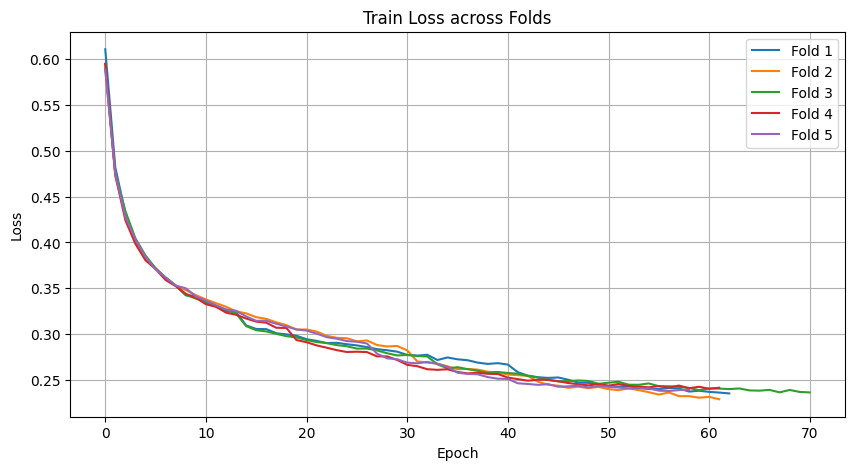

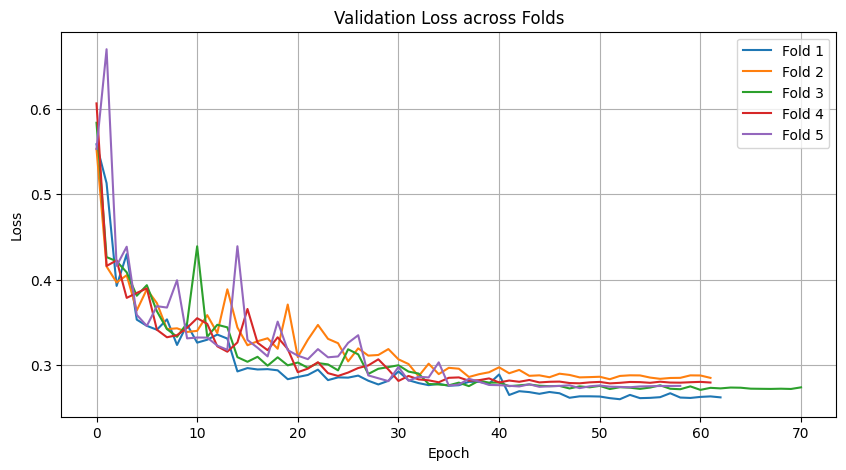

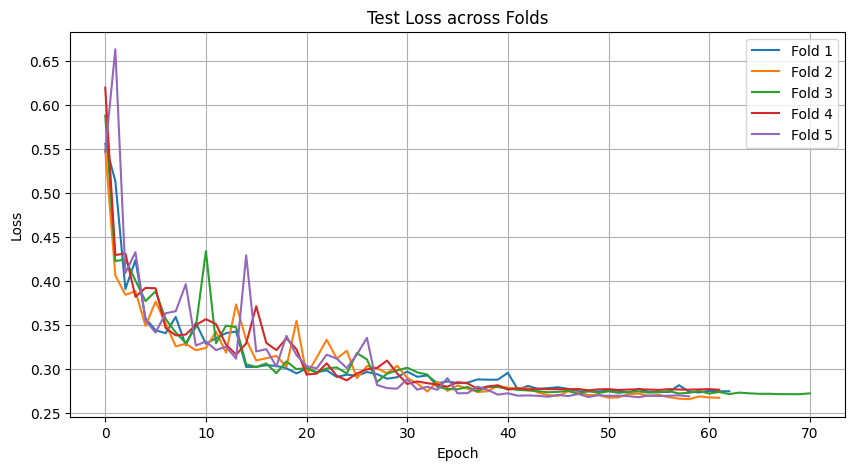

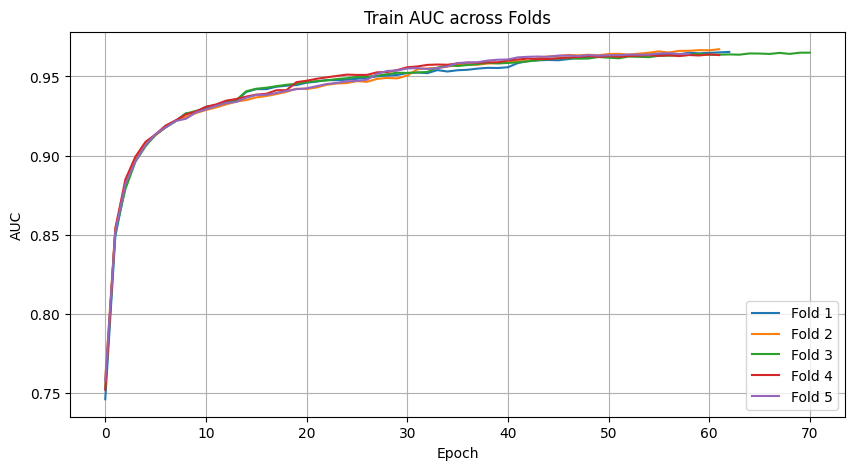

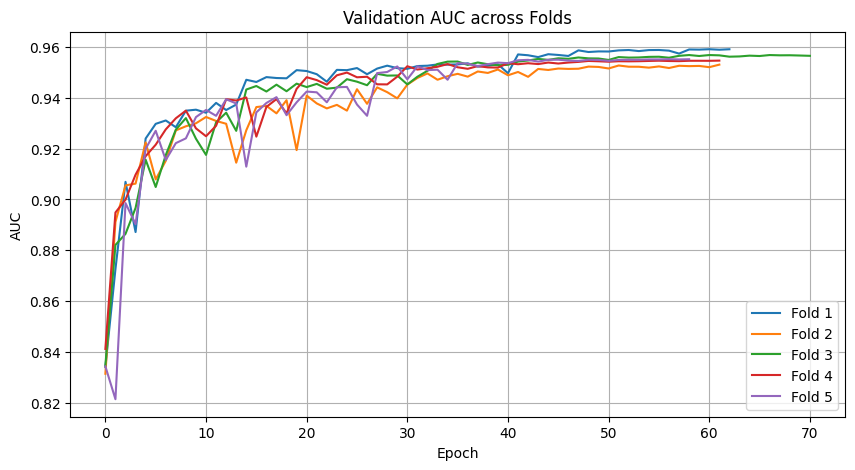

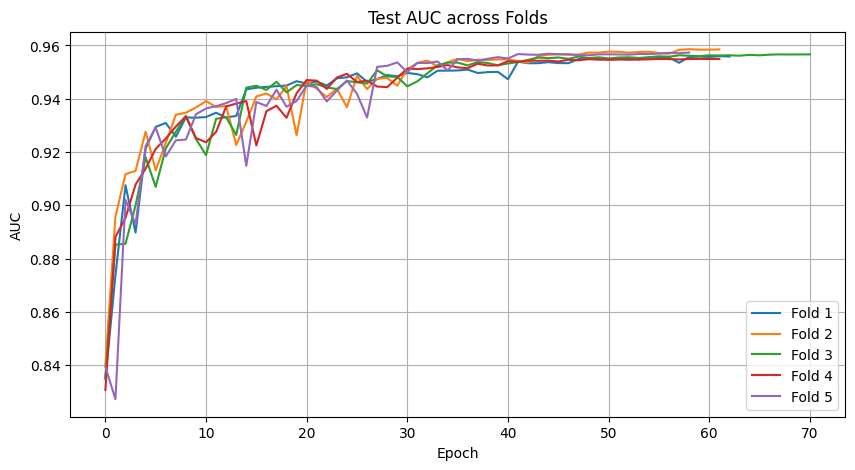

In [ ]:
print("\n\nAverage Metrics Across All Folds:")
for metric in metrics:
    mean = np.mean(metrics[metric])
    std = np.std(metrics[metric])
    print(f"{metric.capitalize()}: {mean:.4f} ± {std:.4f}")

plot_metric_across_folds(all_train_losses, 'Train Loss across Folds', 'Loss')
plot_metric_across_folds(all_val_losses, 'Validation Loss across Folds', 'Loss')
plot_metric_across_folds(all_test_losses, 'Test Loss across Folds', 'Loss')

plot_metric_across_folds(all_train_aucs, 'Train AUC across Folds', 'AUC')
plot_metric_across_folds(all_val_aucs, 'Validation AUC across Folds', 'AUC')
plot_metric_across_folds(all_test_aucs, 'Test AUC across Folds', 'AUC')

##ESM	and Element-wise product and absolute difference concatenate

In [ ]:
metrics = {
    'roc_auc': [],
    'aupr': [],
    'mcc': [],
    'accuracy': [],
    'recall': [],
    'precision': [],
    'f1': [],
    'Specificity':[]
}


def create_model():
    def swish(x):
        return x * tf.nn.sigmoid(x)

    dropout_rate = 0.2
    ac = swish

    # Branch for peptide (320,)
    input_pep = Input(shape=(320,), name='peptide')
    x_pep = layers.Dense(256, activation=ac)(input_pep)
    x_pep = layers.BatchNormalization()(x_pep)
    x_pep = layers.Dropout(dropout_rate)(x_pep)
    x_pep = layers.Dense(128, activation=ac)(x_pep)
    x_pep = layers.BatchNormalization()(x_pep)
    x_pep = layers.Dropout(dropout_rate)(x_pep)
    x_pep = layers.Dense(64, activation=ac)(x_pep)

    # Branch for HLA (320,)
    input_hla = Input(shape=(320,), name='hla')
    x_hla = layers.Dense(256, activation=ac)(input_hla)
    x_hla = layers.BatchNormalization()(x_hla)
    x_hla = layers.Dropout(dropout_rate)(x_hla)
    x_hla = layers.Dense(128, activation=ac)(x_hla)
    x_hla = layers.BatchNormalization()(x_hla)
    x_hla = layers.Dropout(dropout_rate)(x_hla)
    x_hla = layers.Dense(64, activation=ac)(x_hla)

    # Interaction layers
    x1 = layers.Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([x_hla, x_pep])
    x2 = layers.Multiply()([x_pep, x_hla])
    x = layers.Concatenate()([x1, x2])

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(16, activation=ac)(x)

    x= layers.BatchNormalization()(x)
    x= layers.Dropout(dropout_rate)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    # Build model
    model = Model(inputs=[input_hla, input_pep], outputs=output)

    # Optimizer
    try:
        from tensorflow.keras.optimizers.experimental import AdamW
        optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-4)
    except ImportError:
        from tensorflow.keras.optimizers import Adam
        optimizer = Adam(learning_rate=1e-3)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='AUC'),
                 tf.keras.metrics.Recall(name='Recall'),
                 tf.keras.metrics.Precision(name='Precision'),
                 tf.keras.metrics.AUC(name='AUPR', curve='PR')]
    )

    return model


In [ ]:
all_train_losses = []
all_val_losses = []
all_test_losses = []

all_train_aucs = []
all_val_aucs = []
all_test_aucs = []

for fold in range(1, 6):
    print(f"\nFold {fold}/5")
    train_df = pd.read_csv(f"{save_dir}train_fold_{fold}.csv").drop(columns=['Unnamed: 0'])
    val_df = pd.read_csv(f"{save_dir}val_fold_{fold}.csv").drop(columns=['Unnamed: 0'])
    test_df = pd.read_csv(f"{save_dir}test_fold_{fold}.csv").drop(columns=['Unnamed: 0'])


    X_train = train_df.drop(columns=['label', 'HLA', 'peptide'])
    y_train = train_df['label']
    X_val = val_df.drop(columns=['label', 'HLA', 'peptide'])
    y_val = val_df['label']
    X_test = test_df.drop(columns=['label', 'HLA', 'peptide'])
    y_test = test_df['label']


    inputs_train = {
        'peptide': X_train.iloc[:, 9:329].values,
        'hla': X_train.iloc[:, 329:].values,

    }
    inputs_val = {
        'peptide': X_val.iloc[:, 9:329].values,
        'hla': X_val.iloc[:, 329:].values,

    }
    inputs_test = {
        'peptide': X_test.iloc[:, 9:329].values,
        'hla': X_test.iloc[:, 329:].values,

    }



    test_eval_callback = TestEvaluationCallback((inputs_test, y_test))

    model = create_model()
    history = model.fit(
        x=inputs_train,
        y=y_train,
        validation_data=(inputs_val, y_val),
        batch_size=256,
        epochs=100,
        verbose=0,
        callbacks=[
            test_eval_callback,
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
        ]
    )


    #plot_all_metrics_together(history, test_eval_callback, fold)

    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_test_losses.append(test_eval_callback.epoch_metrics['loss'])
    all_train_aucs.append(history.history['AUC'])
    all_val_aucs.append(history.history['val_AUC'])
    all_test_aucs.append(test_eval_callback.epoch_metrics['AUC'])


    y_pred_proba = model.predict(inputs_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    metrics['roc_auc'].append(roc_auc_score(y_test, y_pred_proba))
    metrics['aupr'].append(average_precision_score(y_test, y_pred_proba))
    metrics['mcc'].append(matthews_corrcoef(y_test, y_pred))
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['recall'].append(recall_score(y_test, y_pred))
    metrics['precision'].append(precision_score(y_test, y_pred))
    metrics['f1'].append(f1_score(y_test, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    metrics['Specificity'].append(specificity)

    print(f"\nMetrics for Fold {fold}:")
    print(f"ROC AUC: {metrics['roc_auc'][-1]:.4f}")
    print(f"AUPR: {metrics['aupr'][-1]:.4f}")
    print(f"MCC: {metrics['mcc'][-1]:.4f}")
    print(f"Accuracy: {metrics['accuracy'][-1]:.4f}")
    print(f"Recall: {metrics['recall'][-1]:.4f}")
    print(f"Precision: {metrics['precision'][-1]:.4f}")
    print(f"F1 Score: {metrics['f1'][-1]:.4f}")
    print(f"Specificity: {metrics['Specificity'][-1]:.4f}")




Fold 1/5

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 35: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 41: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 50: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 56: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.

Epoch 61: ReduceLROnPlateau reducing learning rate to 1.5625000742147677e-05.
Epoch 61: early stopping
Restoring model weights from the end of the best epoch: 51.
775/775 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

Metrics for Fold 1:
ROC AUC: 0.9590
AUPR: 0.9567
MCC: 0.7947
Accuracy: 0.8973
Recall: 0.9108
Precision: 0.8885
F1 Score: 0.8995
Specificity: 0.8835

Fold 2/5

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 52: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epo



Average Metrics Across All Folds:
Roc_auc: 0.9591 ± 0.0011
Aupr: 0.9559 ± 0.0015
Mcc: 0.7955 ± 0.0024
Accuracy: 0.8977 ± 0.0011
Recall: 0.9092 ± 0.0060
Precision: 0.8891 ± 0.0019
F1: 0.8990 ± 0.0020
Specificity: 0.8860 ± 0.0043


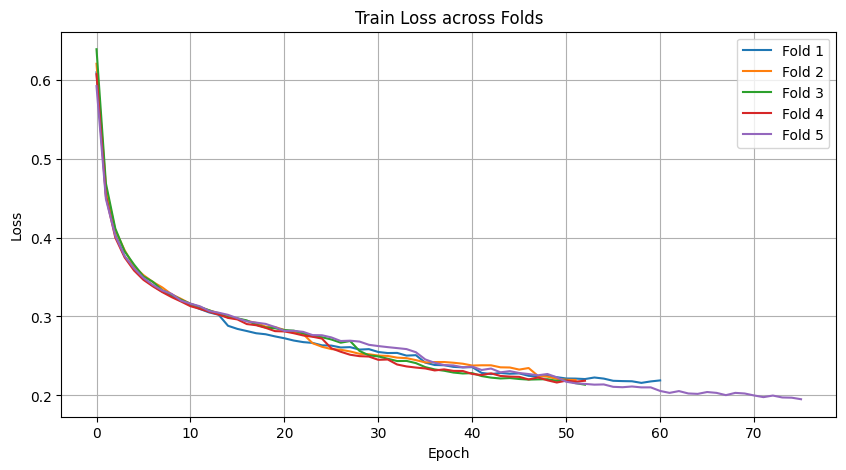

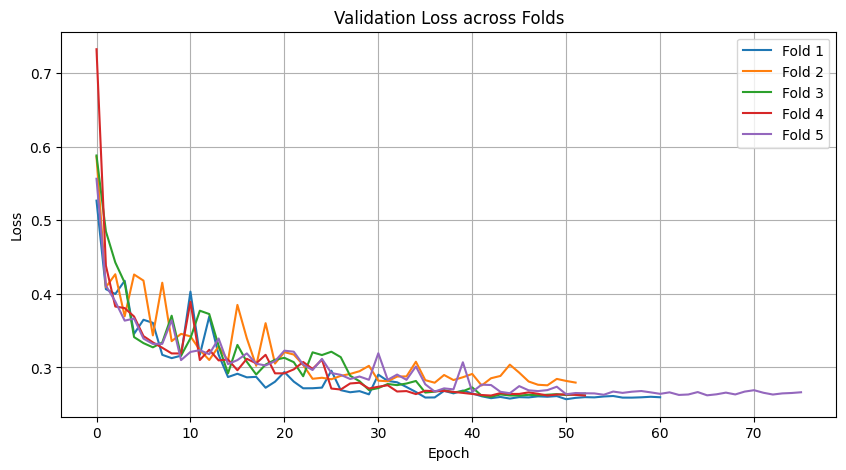

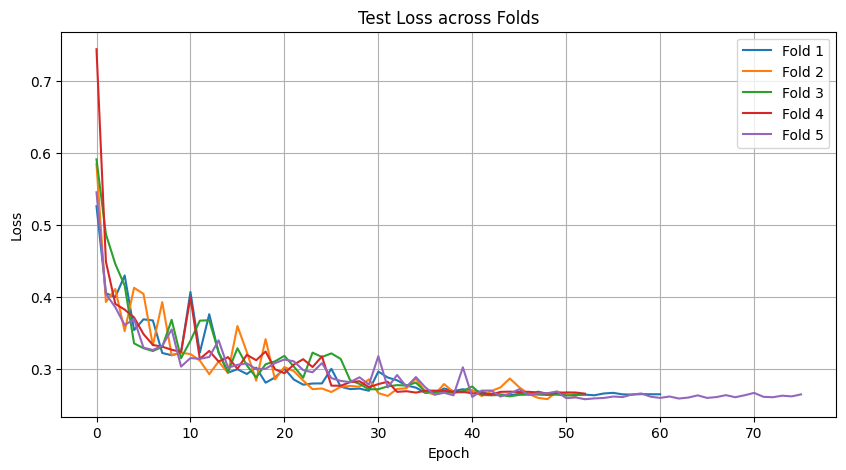

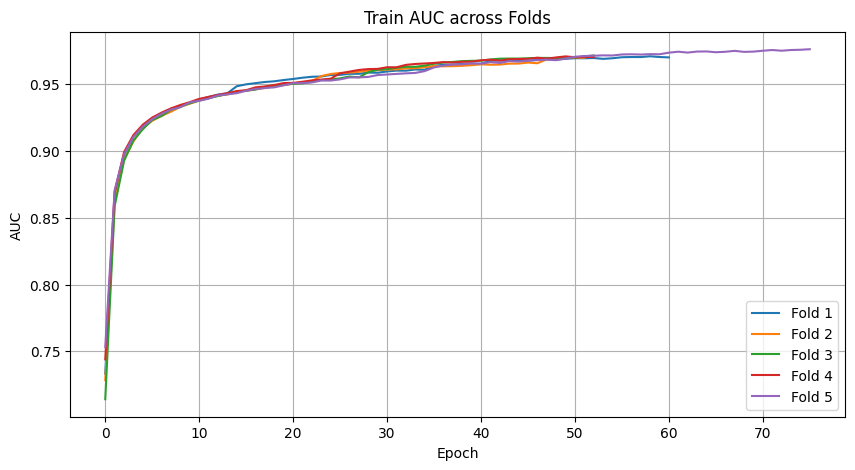

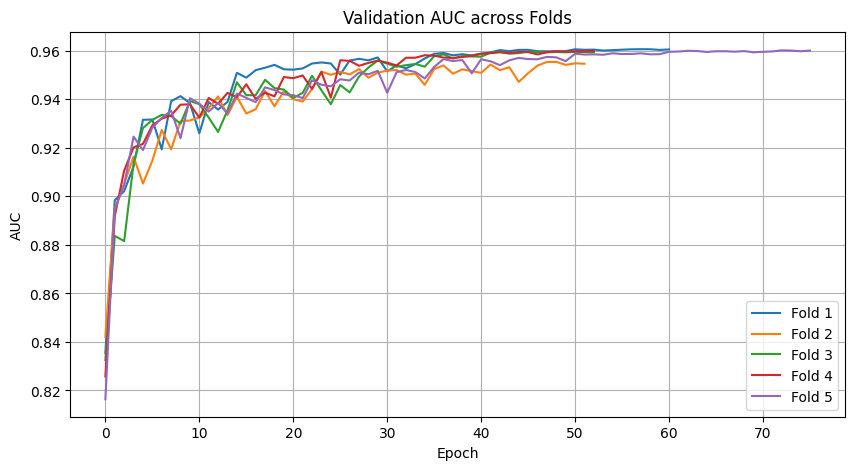

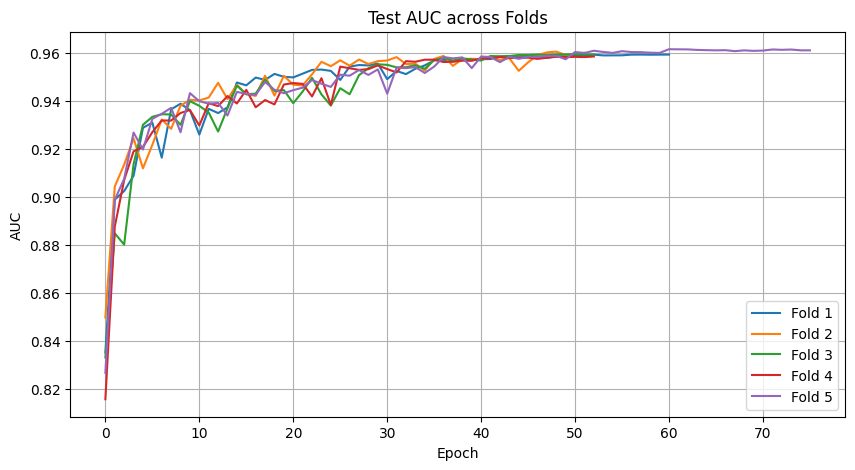

In [ ]:
print("\n\nAverage Metrics Across All Folds:")
for metric in metrics:
    mean = np.mean(metrics[metric])
    std = np.std(metrics[metric])
    print(f"{metric.capitalize()}: {mean:.4f} ± {std:.4f}")

plot_metric_across_folds(all_train_losses, 'Train Loss across Folds', 'Loss')
plot_metric_across_folds(all_val_losses, 'Validation Loss across Folds', 'Loss')
plot_metric_across_folds(all_test_losses, 'Test Loss across Folds', 'Loss')

plot_metric_across_folds(all_train_aucs, 'Train AUC across Folds', 'AUC')
plot_metric_across_folds(all_val_aucs, 'Validation AUC across Folds', 'AUC')
plot_metric_across_folds(all_test_aucs, 'Test AUC across Folds', 'AUC')

##Word2Vec and	Element-wise product and absolute difference concatenate

In [ ]:
!pip install gensim

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 9.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: scipy
    Found existing installation: scipy 1.15.2
    Uninstalling scipy-1.15.2:
      Successfully uninstalled scipy-1.15.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


In [ ]:
!pip install --upgrade numpy
!pip install --upgrade gensim


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 83.0 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires numpy<2.0,>=1.18.5, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
  Attempting uninstall: numpy
    Found e

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np

def generate_kmers(seq, k=3):
    return [seq[i:i+k] for i in range(len(seq) - k + 1)]

def sequence_to_embedding(seq, model, k=3):
    kmers = generate_kmers(seq, k)
    vectors = [model.wv[kmer] for kmer in kmers if kmer in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

def embed_dataframe(df):
    peptide_emb = np.vstack(df['peptide'].apply(lambda x: sequence_to_embedding(x, w2v_model)))
    hla_emb = np.vstack(df['HLA'].apply(lambda x: sequence_to_embedding(x, w2v_model)))
    return np.hstack([peptide_emb, hla_emb])

In [ ]:
metrics = {
    'roc_auc': [],
    'aupr': [],
    'mcc': [],
    'accuracy': [],
    'recall': [],
    'precision': [],
    'f1': [],
    'Specificity':[]
}


def create_model():
    def swish(x):
        return x * tf.nn.sigmoid(x)

    dropout_rate = 0.2
    ac = swish

    input_pep = Input(shape=(100,), name='peptide')
    x_pep = layers.Dense(64, activation=ac)(input_pep)
    x_pep = layers.BatchNormalization()(x_pep)
    x_pep = layers.Dropout(dropout_rate)(x_pep)
    x_pep = layers.Dense(32, activation=ac)(x_pep)
    x_pep = layers.BatchNormalization()(x_pep)
    x_pep = layers.Dropout(dropout_rate)(x_pep)
    x_pep = layers.Dense(16, activation=ac)(x_pep)

    input_hla = Input(shape=(100,), name='hla')
    x_hla = layers.Dense(64, activation=ac)(input_hla)
    x_hla = layers.BatchNormalization()(x_hla)
    x_hla = layers.Dropout(dropout_rate)(x_hla)
    x_hla = layers.Dense(32, activation=ac)(x_hla)
    x_hla = layers.BatchNormalization()(x_hla)
    x_hla = layers.Dropout(dropout_rate)(x_hla)
    x_hla = layers.Dense(16, activation=ac)(x_hla)

    x1 = layers.Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([x_hla, x_pep])
    x2 = layers.Multiply()([x_pep, x_hla])
    x = layers.Concatenate()([x1, x2])

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(16, activation=ac)(x)


    x= layers.BatchNormalization()(x)
    x= layers.Dropout(dropout_rate)(x)
    output = layers.Dense(1, activation='sigmoid')(x)


    model = Model(inputs=[input_pep, input_hla], outputs=output)


    try:
        from tensorflow.keras.optimizers.experimental import AdamW
        optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-4)
    except ImportError:
        from tensorflow.keras.optimizers import Adam
        optimizer = Adam(learning_rate=1e-3)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='AUC'),
                 tf.keras.metrics.Recall(name='Recall'),
                 tf.keras.metrics.Precision(name='Precision'),
                 tf.keras.metrics.AUC(name='AUPR', curve='PR')]
    )

    return model


In [ ]:
all_train_losses = []
all_val_losses = []
all_test_losses = []

all_train_aucs = []
all_val_aucs = []
all_test_aucs = []

for fold in range(1, 6):
    print(f"\nFold {fold}/5")
    train_df = pd.read_csv(f"{save_dir}train_fold_{fold}.csv").drop(columns=['Unnamed: 0'])
    val_df = pd.read_csv(f"{save_dir}val_fold_{fold}.csv").drop(columns=['Unnamed: 0'])
    test_df = pd.read_csv(f"{save_dir}test_fold_{fold}.csv").drop(columns=['Unnamed: 0'])


    train_sequences = pd.concat([train_df['HLA'], train_df['peptide']])
    train_sentences = [generate_kmers(seq) for seq in train_sequences]

    w2v_model = Word2Vec(train_sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1)

    X_train_embed = embed_dataframe(train_df)
    X_val_embed   = embed_dataframe(val_df)
    X_test_embed  = embed_dataframe(test_df)

    y_train = train_df['label']
    y_val = val_df['label']
    y_test = test_df['label']

    inputs_train = {
        'peptide': X_train_embed[:, :100],
        'hla':     X_train_embed[:, 100:]
    }
    inputs_val = {
        'peptide': X_val_embed[:, :100],
        'hla':     X_val_embed[:, 100:]
    }
    inputs_test = {
        'peptide': X_test_embed[:, :100],
        'hla':     X_test_embed[:, 100:]
    }


    test_eval_callback = TestEvaluationCallback((inputs_test, y_test))

    model = create_model()
    history = model.fit(
        x=inputs_train,
        y=y_train,
        validation_data=(inputs_val, y_val),
        batch_size=256,
        epochs=100,
        verbose=0,
        callbacks=[
            test_eval_callback,
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
        ]
    )



    #plot_all_metrics_together(history, test_eval_callback, fold)

    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_test_losses.append(test_eval_callback.epoch_metrics['loss'])
    all_train_aucs.append(history.history['AUC'])
    all_val_aucs.append(history.history['val_AUC'])
    all_test_aucs.append(test_eval_callback.epoch_metrics['AUC'])


    y_pred_proba = model.predict(inputs_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    metrics['roc_auc'].append(roc_auc_score(y_test, y_pred_proba))
    metrics['aupr'].append(average_precision_score(y_test, y_pred_proba))
    metrics['mcc'].append(matthews_corrcoef(y_test, y_pred))
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['recall'].append(recall_score(y_test, y_pred))
    metrics['precision'].append(precision_score(y_test, y_pred))
    metrics['f1'].append(f1_score(y_test, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    metrics['Specificity'].append(specificity)

    print(f"\nMetrics for Fold {fold}:")
    print(f"ROC AUC: {metrics['roc_auc'][-1]:.4f}")
    print(f"AUPR: {metrics['aupr'][-1]:.4f}")
    print(f"MCC: {metrics['mcc'][-1]:.4f}")
    print(f"Accuracy: {metrics['accuracy'][-1]:.4f}")
    print(f"Recall: {metrics['recall'][-1]:.4f}")
    print(f"Precision: {metrics['precision'][-1]:.4f}")
    print(f"F1 Score: {metrics['f1'][-1]:.4f}")
    print(f"Specificity: {metrics['Specificity'][-1]:.4f}")


Fold 1/5

Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 63: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 89: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 95: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 99.
775/775 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Metrics for Fold 1:
ROC AUC: 0.8038
AUPR: 0.7935
MCC: 0.4557
Accuracy: 0.7269
Recall: 0.7828
Precision: 0.7074
F1 Score: 0.7432
Specificity: 0.6699

Fold 2/5

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 91: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Restoring model weights from the end of the best epoch: 100.
775/775 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Metrics for Fold 2:
ROC AUC: 0.8077
AUPR: 0.7936
MCC: 0.4602
Accuracy: 0.7294
Recall: 0.7675
Precision: 0.7136
F1 Score: 0.7396
Specificity: 0.6913

Fold 3/5

E



Average Metrics Across All Folds:
Roc_auc: 0.8029 ± 0.0046
Aupr: 0.7895 ± 0.0085
Mcc: 0.4532 ± 0.0077
Accuracy: 0.7255 ± 0.0042
Recall: 0.7747 ± 0.0080
Precision: 0.7063 ± 0.0076
F1: 0.7388 ± 0.0050
Specificity: 0.6762 ± 0.0102


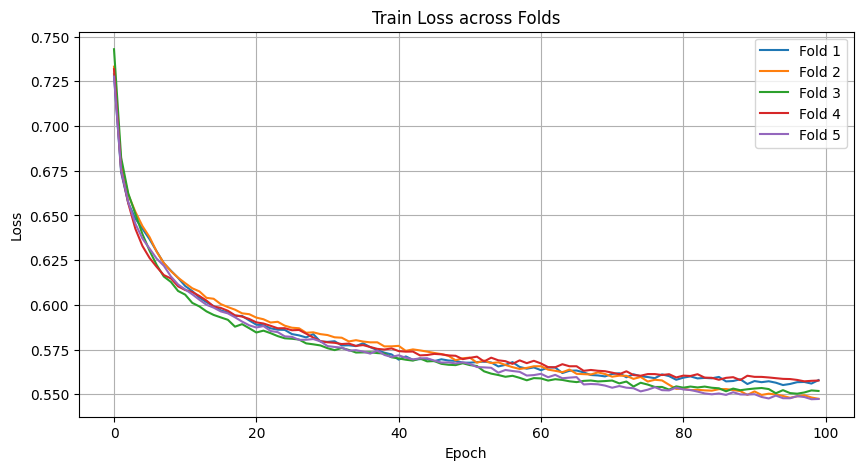

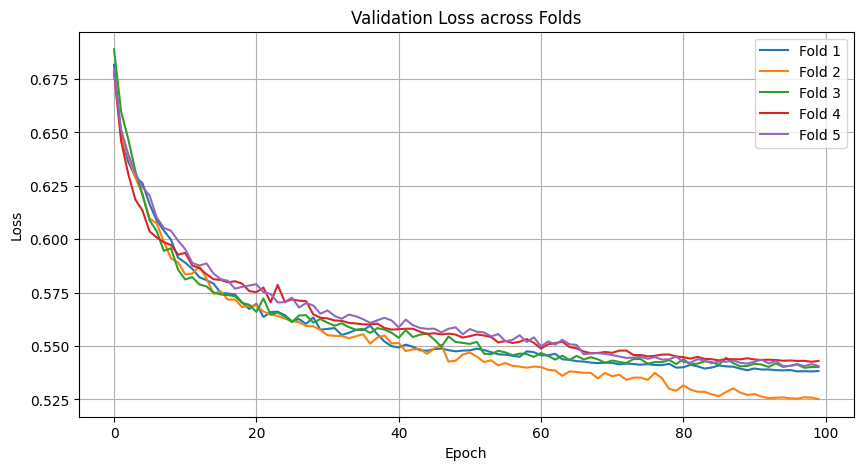

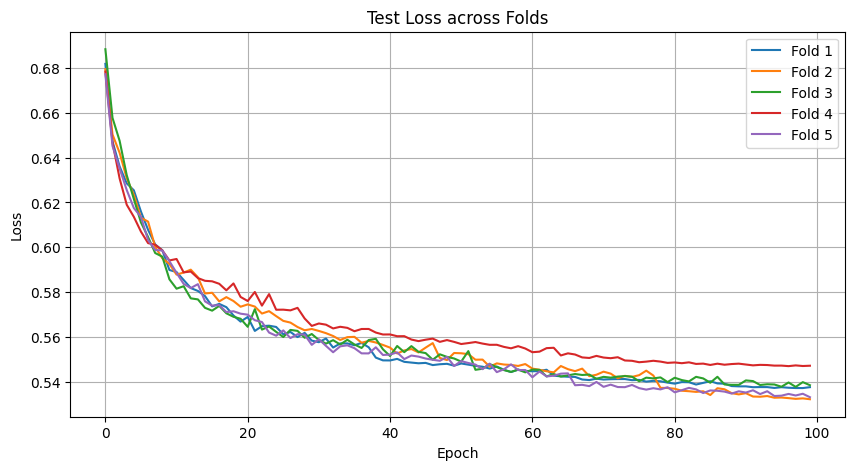

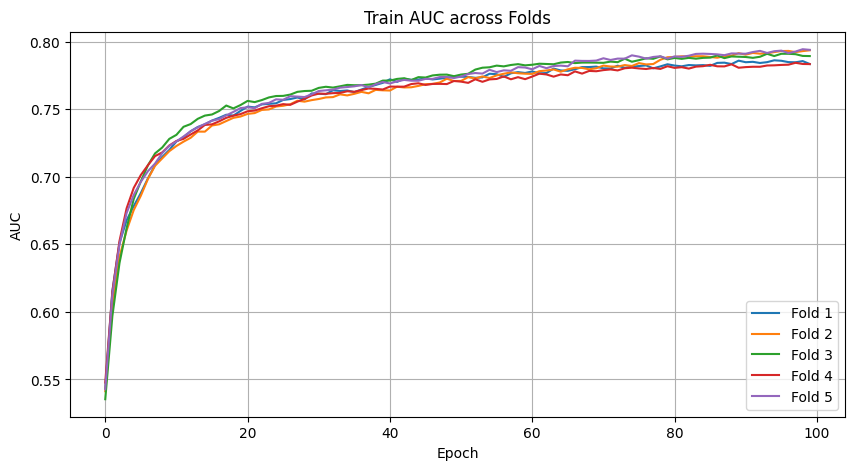

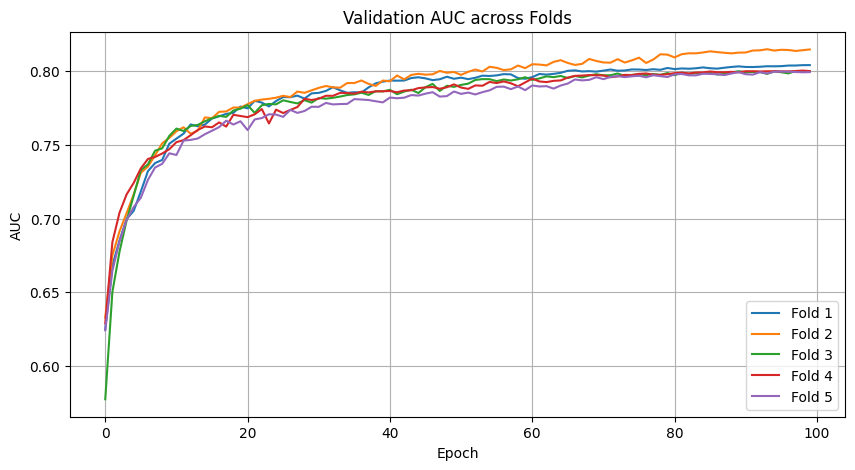

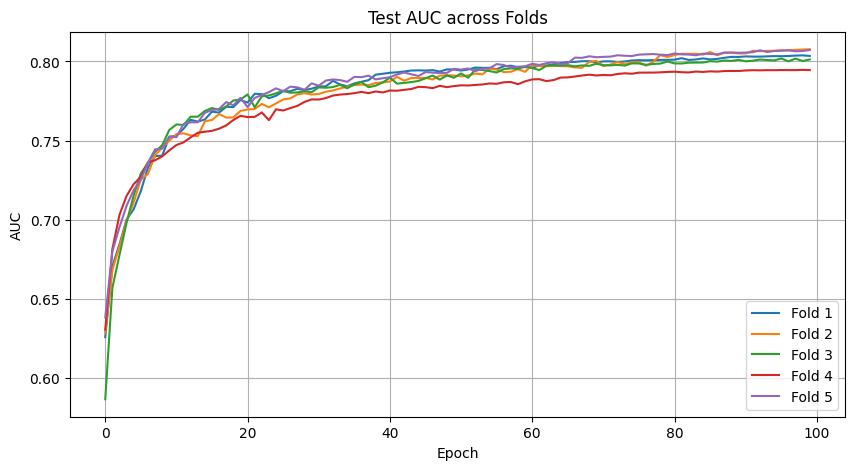

In [ ]:
print("\n\nAverage Metrics Across All Folds:")
for metric in metrics:
    mean = np.mean(metrics[metric])
    std = np.std(metrics[metric])
    print(f"{metric.capitalize()}: {mean:.4f} ± {std:.4f}")

# Loss plots
plot_metric_across_folds(all_train_losses, 'Train Loss across Folds', 'Loss')
plot_metric_across_folds(all_val_losses, 'Validation Loss across Folds', 'Loss')
plot_metric_across_folds(all_test_losses, 'Test Loss across Folds', 'Loss')

# AUC plots
plot_metric_across_folds(all_train_aucs, 'Train AUC across Folds', 'AUC')
plot_metric_across_folds(all_val_aucs, 'Validation AUC across Folds', 'AUC')
plot_metric_across_folds(all_test_aucs, 'Test AUC across Folds', 'AUC')

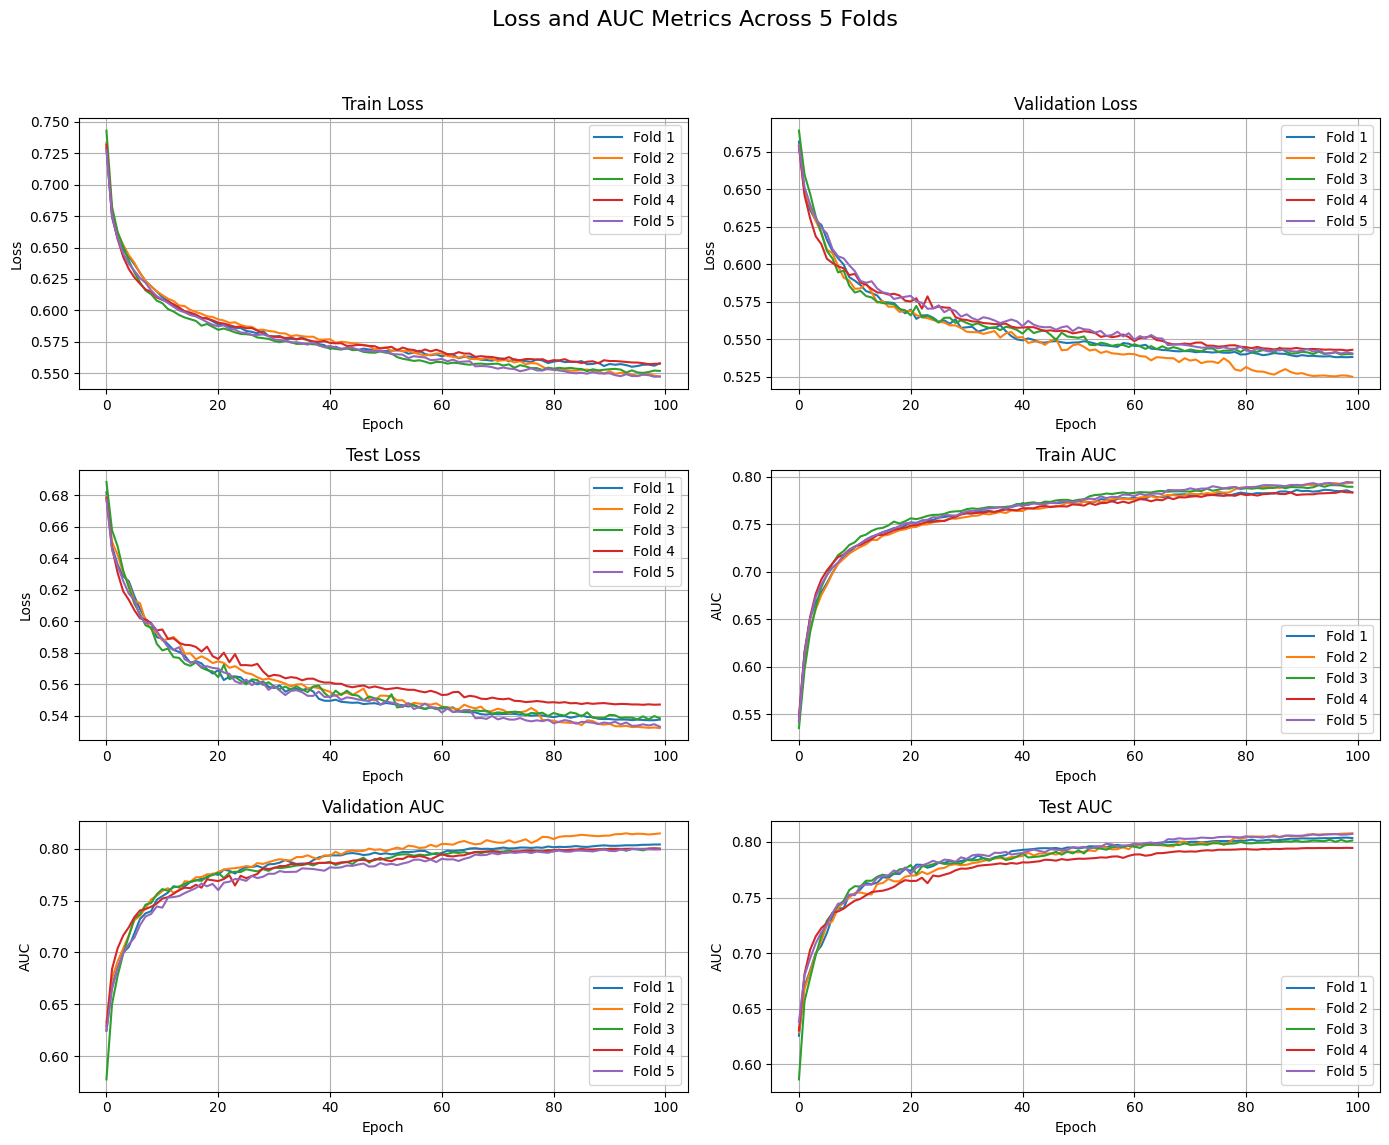

In [ ]:
plot_combined_metrics_across_folds(
    all_train_losses, all_val_losses, all_test_losses,
    all_train_aucs, all_val_aucs, all_test_aucs
)


##  Word2Vec and	Concatenation of HLA and peptide embeddings

In [ ]:
import pandas as pd
from gensim.models import Word2Vec
import numpy as np


def generate_kmers(seq, k=3):
    return [seq[i:i+k] for i in range(len(seq) - k + 1)]

def sequence_to_embedding(seq, model, k=3):
    kmers = generate_kmers(seq, k)
    vectors = [model.wv[kmer] for kmer in kmers if kmer in model.wv]
    if vectors:
        return np.mean(vectors, axis=0)
    else:
        return np.zeros(model.vector_size)

def embed_dataframe(df):
    peptide_emb = np.vstack(df['peptide'].apply(lambda x: sequence_to_embedding(x, w2v_model)))
    hla_emb = np.vstack(df['HLA'].apply(lambda x: sequence_to_embedding(x, w2v_model)))
    return np.hstack([peptide_emb, hla_emb])

In [ ]:
metrics = {
    'roc_auc': [],
    'aupr': [],
    'mcc': [],
    'accuracy': [],
    'recall': [],
    'precision': [],
    'f1': [],
    'Specificity':[]
}


def create_model():
    def swish(x):
        return x * tf.nn.sigmoid(x)

    dropout_rate = 0.2
    ac = swish


    input_pep = Input(shape=(100,), name='peptide')
    x_pep = layers.Dense(64, activation=ac)(input_pep)
    x_pep = layers.BatchNormalization()(x_pep)
    x_pep = layers.Dropout(dropout_rate)(x_pep)
    x_pep = layers.Dense(32, activation=ac)(x_pep)
    x_pep = layers.BatchNormalization()(x_pep)
    x_pep = layers.Dropout(dropout_rate)(x_pep)
    x_pep = layers.Dense(16, activation=ac)(x_pep)


    input_hla = Input(shape=(100,), name='hla')
    x_hla = layers.Dense(64, activation=ac)(input_hla)
    x_hla = layers.BatchNormalization()(x_hla)
    x_hla = layers.Dropout(dropout_rate)(x_hla)
    x_hla = layers.Dense(32, activation=ac)(x_hla)
    x_hla = layers.BatchNormalization()(x_hla)
    x_hla = layers.Dropout(dropout_rate)(x_hla)
    x_hla = layers.Dense(16, activation=ac)(x_hla)


    x = layers.Concatenate()([x_pep, x_hla])

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(16, activation=ac)(x)


    x= layers.BatchNormalization()(x)
    x= layers.Dropout(dropout_rate)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_pep, input_hla], outputs=output)

    try:
        from tensorflow.keras.optimizers.experimental import AdamW
        optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-4)
    except ImportError:
        from tensorflow.keras.optimizers import Adam
        optimizer = Adam(learning_rate=1e-3)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='AUC'),
                 tf.keras.metrics.Recall(name='Recall'),
                 tf.keras.metrics.Precision(name='Precision'),
                 tf.keras.metrics.AUC(name='AUPR', curve='PR')]
    )

    return model

In [ ]:
all_train_losses = []
all_val_losses = []
all_test_losses = []

all_train_aucs = []
all_val_aucs = []
all_test_aucs = []

for fold in range(1, 6):
    print(f"\nFold {fold}/5")
    train_df = pd.read_csv(f"{save_dir}train_fold_{fold}.csv").drop(columns=['Unnamed: 0'])
    val_df = pd.read_csv(f"{save_dir}val_fold_{fold}.csv").drop(columns=['Unnamed: 0'])
    test_df = pd.read_csv(f"{save_dir}test_fold_{fold}.csv").drop(columns=['Unnamed: 0'])


    train_sequences = pd.concat([train_df['HLA'], train_df['peptide']])
    train_sentences = [generate_kmers(seq) for seq in train_sequences]

    w2v_model = Word2Vec(train_sentences, vector_size=100, window=5, min_count=1, workers=4, sg=1)

    X_train_embed = embed_dataframe(train_df)
    X_val_embed   = embed_dataframe(val_df)
    X_test_embed  = embed_dataframe(test_df)

    y_train = train_df['label']
    y_val = val_df['label']
    y_test = test_df['label']

    inputs_train = {
        'peptide': X_train_embed[:, :100],
        'hla':     X_train_embed[:, 100:]
    }
    inputs_val = {
        'peptide': X_val_embed[:, :100],
        'hla':     X_val_embed[:, 100:]
    }
    inputs_test = {
        'peptide': X_test_embed[:, :100],
        'hla':     X_test_embed[:, 100:]
    }


    test_eval_callback = TestEvaluationCallback((inputs_test, y_test))

    model = create_model()
    history = model.fit(
        x=inputs_train,
        y=y_train,
        validation_data=(inputs_val, y_val),
        batch_size=256,
        epochs=100,
        verbose=0,
        callbacks=[
            test_eval_callback,
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
        ]
    )


    #plot_all_metrics_together(history, test_eval_callback, fold)

    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_test_losses.append(test_eval_callback.epoch_metrics['loss'])
    all_train_aucs.append(history.history['AUC'])
    all_val_aucs.append(history.history['val_AUC'])
    all_test_aucs.append(test_eval_callback.epoch_metrics['AUC'])


    y_pred_proba = model.predict(inputs_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    metrics['roc_auc'].append(roc_auc_score(y_test, y_pred_proba))
    metrics['aupr'].append(average_precision_score(y_test, y_pred_proba))
    metrics['mcc'].append(matthews_corrcoef(y_test, y_pred))
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['recall'].append(recall_score(y_test, y_pred))
    metrics['precision'].append(precision_score(y_test, y_pred))
    metrics['f1'].append(f1_score(y_test, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    metrics['Specificity'].append(specificity)

    print(f"\nMetrics for Fold {fold}:")
    print(f"ROC AUC: {metrics['roc_auc'][-1]:.4f}")
    print(f"AUPR: {metrics['aupr'][-1]:.4f}")
    print(f"MCC: {metrics['mcc'][-1]:.4f}")
    print(f"Accuracy: {metrics['accuracy'][-1]:.4f}")
    print(f"Recall: {metrics['recall'][-1]:.4f}")
    print(f"Precision: {metrics['precision'][-1]:.4f}")
    print(f"F1 Score: {metrics['f1'][-1]:.4f}")
    print(f"Specificity: {metrics['Specificity'][-1]:.4f}")


Fold 1/5

Epoch 49: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 64: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 95: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Restoring model weights from the end of the best epoch: 99.
775/775 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

Metrics for Fold 1:
ROC AUC: 0.7860
AUPR: 0.7776
MCC: 0.4188
Accuracy: 0.7091
Recall: 0.7456
Precision: 0.6986
F1 Score: 0.7213
Specificity: 0.6720

Fold 2/5

Epoch 57: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 65: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 93: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 99: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Restoring model weights from t



Average Metrics Across All Folds:
Roc_auc: 0.7878 ± 0.0033
Aupr: 0.7765 ± 0.0042
Mcc: 0.4248 ± 0.0092
Accuracy: 0.7119 ± 0.0045
Recall: 0.7490 ± 0.0088
Precision: 0.6981 ± 0.0043
F1: 0.7226 ± 0.0055
Specificity: 0.6745 ± 0.0036


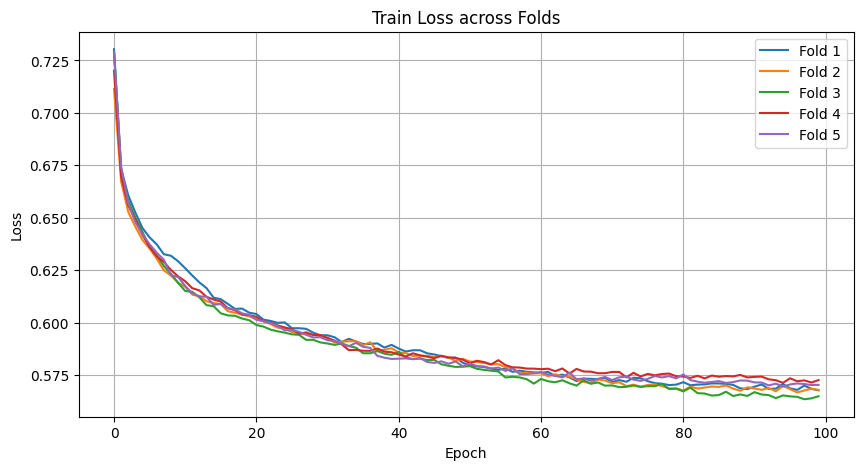

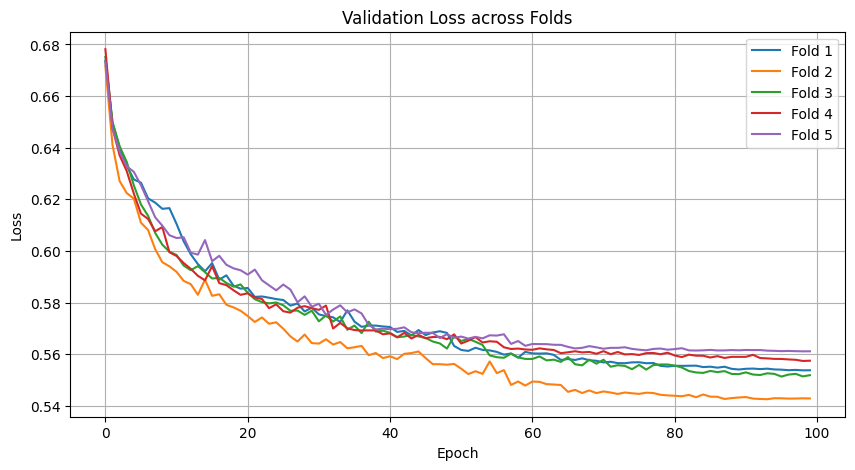

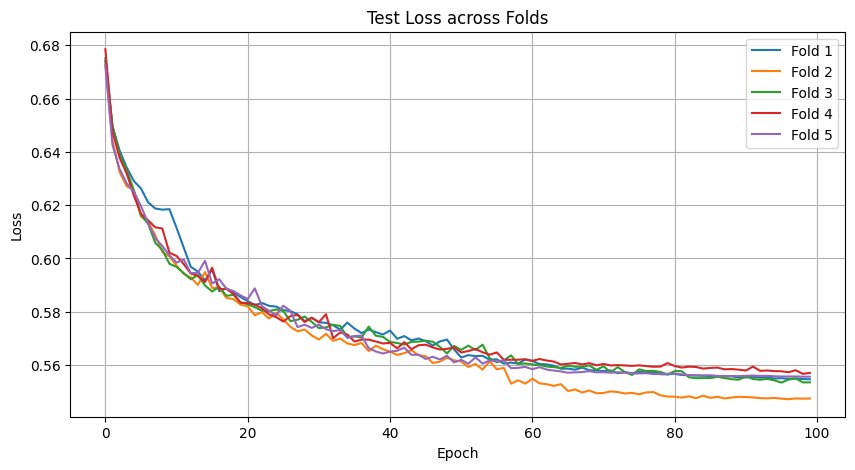

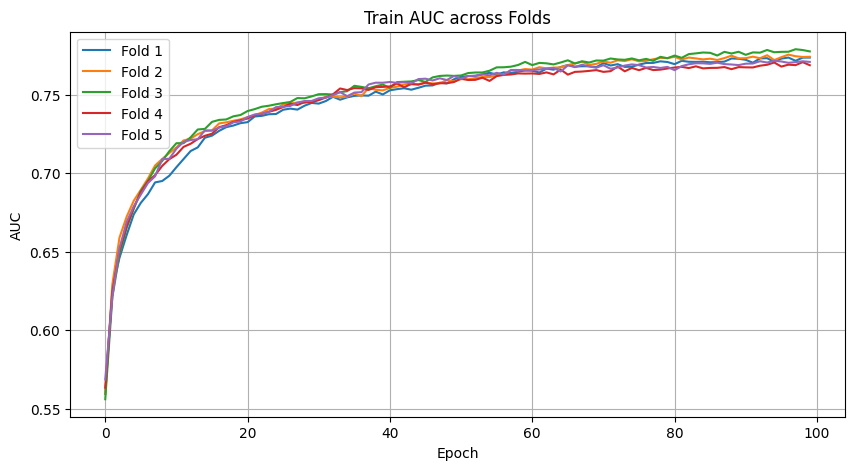

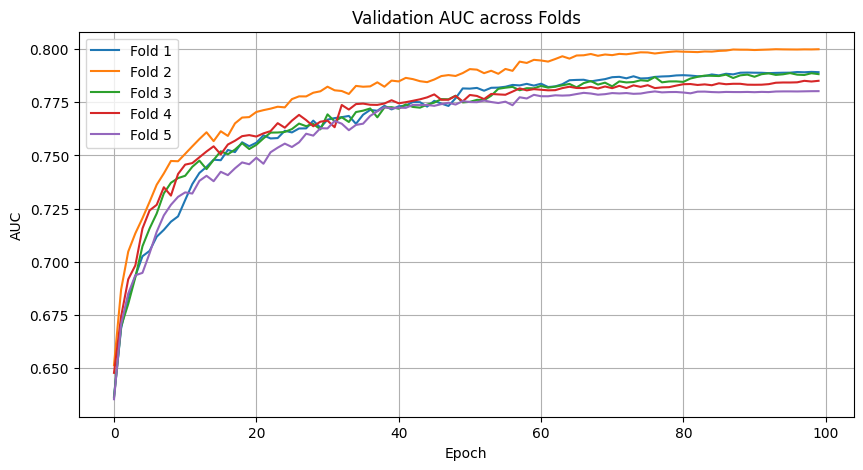

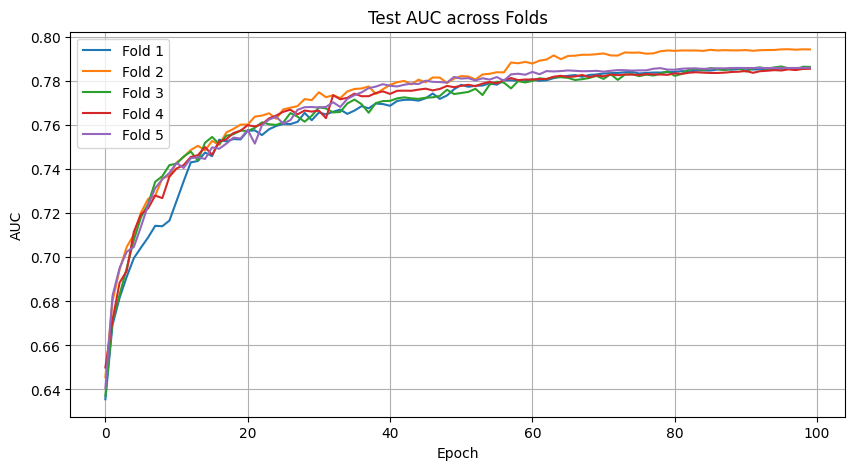

In [ ]:
print("\n\nAverage Metrics Across All Folds:")
for metric in metrics:
    mean = np.mean(metrics[metric])
    std = np.std(metrics[metric])
    print(f"{metric.capitalize()}: {mean:.4f} ± {std:.4f}")

plot_metric_across_folds(all_train_losses, 'Train Loss across Folds', 'Loss')
plot_metric_across_folds(all_val_losses, 'Validation Loss across Folds', 'Loss')
plot_metric_across_folds(all_test_losses, 'Test Loss across Folds', 'Loss')

plot_metric_across_folds(all_train_aucs, 'Train AUC across Folds', 'AUC')
plot_metric_across_folds(all_val_aucs, 'Validation AUC across Folds', 'AUC')
plot_metric_across_folds(all_test_aucs, 'Test AUC across Folds', 'AUC')

##Incorporating IEDB scores into TriSiamHP model

###Element-wise product and absolute difference concatenate (***SiaScoreNet***)

In [ ]:
metrics = {
    'roc_auc': [],
    'aupr': [],
    'mcc': [],
    'accuracy': [],
    'recall': [],
    'precision': [],
    'f1': [],
    'Specificity':[]
}


def create_model():
    def swish(x):
        return x * tf.nn.sigmoid(x)

    dropout_rate = 0.2
    ac = swish

    input_pep = Input(shape=(320,), name='peptide')
    x_pep = layers.Dense(256, activation=ac)(input_pep)
    x_pep = layers.BatchNormalization()(x_pep)
    x_pep = layers.Dropout(dropout_rate)(x_pep)
    x_pep = layers.Dense(128, activation=ac)(x_pep)
    x_pep = layers.BatchNormalization()(x_pep)
    x_pep = layers.Dropout(dropout_rate)(x_pep)
    x_pep = layers.Dense(64, activation=ac)(x_pep)

    input_hla = Input(shape=(320,), name='hla')
    x_hla = layers.Dense(256, activation=ac)(input_hla)
    x_hla = layers.BatchNormalization()(x_hla)
    x_hla = layers.Dropout(dropout_rate)(x_hla)
    x_hla = layers.Dense(128, activation=ac)(x_hla)
    x_hla = layers.BatchNormalization()(x_hla)
    x_hla = layers.Dropout(dropout_rate)(x_hla)
    x_hla = layers.Dense(64, activation=ac)(x_hla)

    x1 = layers.Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([x_hla, x_pep])
    x2 = layers.Multiply()([x_pep, x_hla])
    x = layers.Concatenate()([x1, x2])

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(16, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(8, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(1, activation=ac)(x)

    input_scores = Input(shape=(9,), name='scores')
    x = layers.Concatenate()([x, input_scores])
    x= layers.BatchNormalization()(x)
    x= layers.Dropout(dropout_rate)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_pep, input_hla, input_scores], outputs=output)

    try:
        from tensorflow.keras.optimizers.experimental import AdamW
        optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-4)
    except ImportError:
        from tensorflow.keras.optimizers import Adam
        optimizer = Adam(learning_rate=1e-3)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='AUC'),
                 tf.keras.metrics.Recall(name='Recall'),
                 tf.keras.metrics.Precision(name='Precision'),
                 tf.keras.metrics.AUC(name='AUPR', curve='PR')]
    )

    return model

test_eval_callback = TestEvaluationCallback(([X_val_peptide, X_val_mhc, X_val_ens], y_val))
callbacks = [
    test_eval_callback,
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

In [ ]:
all_train_losses = []
all_val_losses = []
all_test_losses = []

all_train_aucs = []
all_val_aucs = []
all_test_aucs = []


for fold in range(1, 6):
    print(f"\nFold {fold}/5")
    train_df = pd.read_csv(f"{save_dir}train_fold_{fold}.csv").drop(columns=['Unnamed: 0'])
    val_df = pd.read_csv(f"{save_dir}val_fold_{fold}.csv").drop(columns=['Unnamed: 0'])
    test_df = pd.read_csv(f"{save_dir}test_fold_{fold}.csv").drop(columns=['Unnamed: 0'])

    X_train = train_df.drop(columns=['label', 'HLA', 'peptide'])
    y_train = train_df['label']
    X_val = val_df.drop(columns=['label', 'HLA', 'peptide'])
    y_val = val_df['label']
    X_test = test_df.drop(columns=['label', 'HLA', 'peptide'])
    y_test = test_df['label']


    inputs_train = {
        'peptide': X_train.iloc[:, 9:329].values,
        'hla': X_train.iloc[:, 329:].values,
        'scores': X_train.iloc[:, :9].values
    }
    inputs_val = {
        'peptide': X_val.iloc[:, 9:329].values,
        'hla': X_val.iloc[:, 329:].values,
        'scores': X_val.iloc[:, :9].values
    }
    inputs_test = {
        'peptide': X_test.iloc[:, 9:329].values,
        'hla': X_test.iloc[:, 329:].values,
        'scores': X_test.iloc[:, :9].values
    }

    test_eval_callback = TestEvaluationCallback((inputs_test, y_test))

    model = create_model()
    history = model.fit(
        x=inputs_train,
        y=y_train,
        validation_data=(inputs_val, y_val),
        batch_size=256,
        epochs=100,
        verbose=0,
        callbacks=[
            test_eval_callback,
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
        ]
    )

    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_test_losses.append(test_eval_callback.epoch_metrics['loss'])
    all_train_aucs.append(history.history['AUC'])
    all_val_aucs.append(history.history['val_AUC'])
    all_test_aucs.append(test_eval_callback.epoch_metrics['AUC'])


    y_pred_proba = model.predict(inputs_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    metrics['roc_auc'].append(roc_auc_score(y_test, y_pred_proba))
    metrics['aupr'].append(average_precision_score(y_test, y_pred_proba))
    metrics['mcc'].append(matthews_corrcoef(y_test, y_pred))
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['recall'].append(recall_score(y_test, y_pred))
    metrics['precision'].append(precision_score(y_test, y_pred))
    metrics['f1'].append(f1_score(y_test, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    metrics['Specificity'].append(specificity)

    print(f"\nMetrics for Fold {fold}:")
    print(f"ROC AUC: {metrics['roc_auc'][-1]:.4f}")
    print(f"AUPR: {metrics['aupr'][-1]:.4f}")
    print(f"MCC: {metrics['mcc'][-1]:.4f}")
    print(f"Accuracy: {metrics['accuracy'][-1]:.4f}")
    print(f"Recall: {metrics['recall'][-1]:.4f}")
    print(f"Precision: {metrics['precision'][-1]:.4f}")
    print(f"F1 Score: {metrics['f1'][-1]:.4f}")
    print(f"Specificity: {metrics['Specificity'][-1]:.4f}")


Fold 1/5

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 46: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 51: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 51: early stopping
Restoring model weights from the end of the best epoch: 41.
775/775 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

Metrics for Fold 1:
ROC AUC: 0.9767
AUPR: 0.9776
MCC: 0.8515
Accuracy: 0.9258
Recall: 0.9306
Precision: 0.9229
F1 Score: 0.9268
Specificity: 0.9208

Fold 2/5

Epoch 26: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 47: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 57: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoc

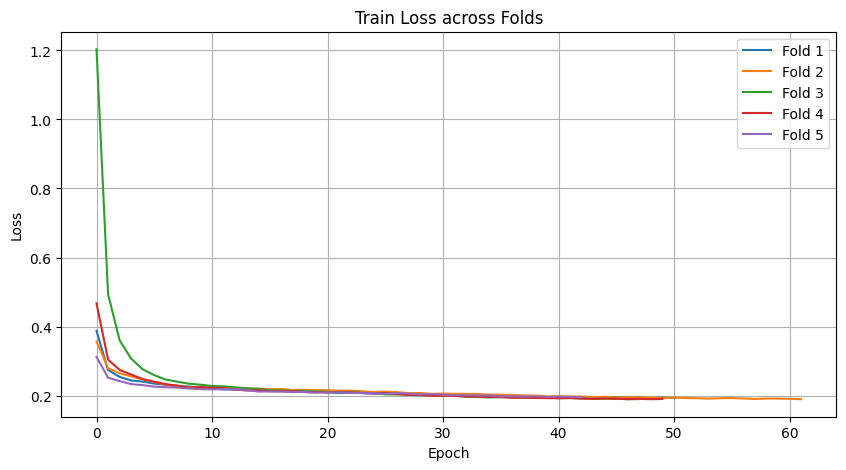

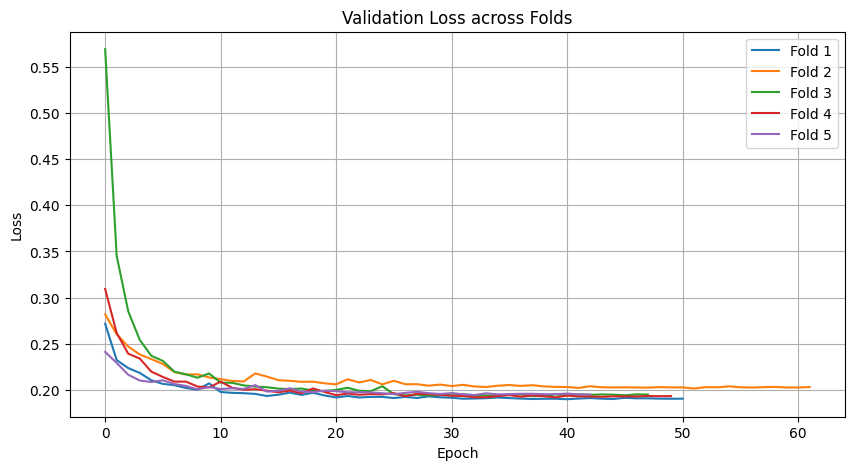

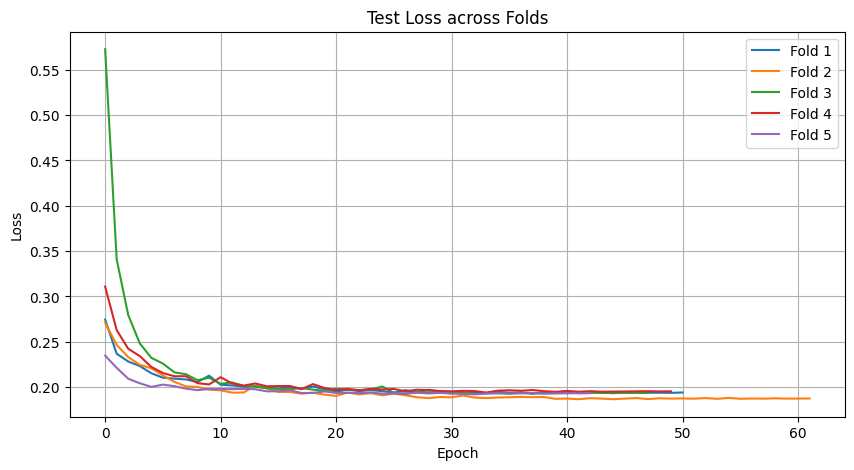

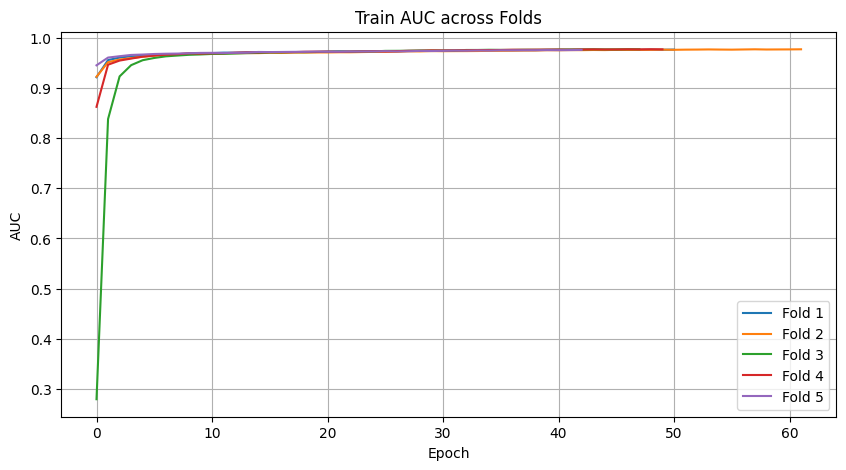

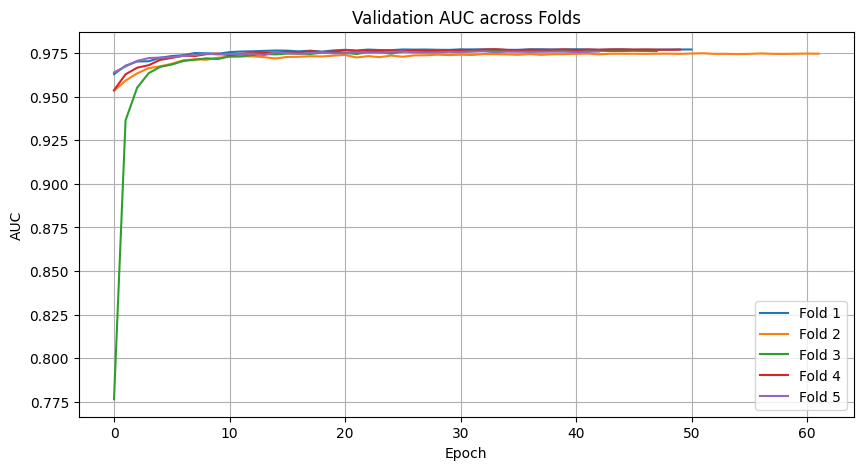

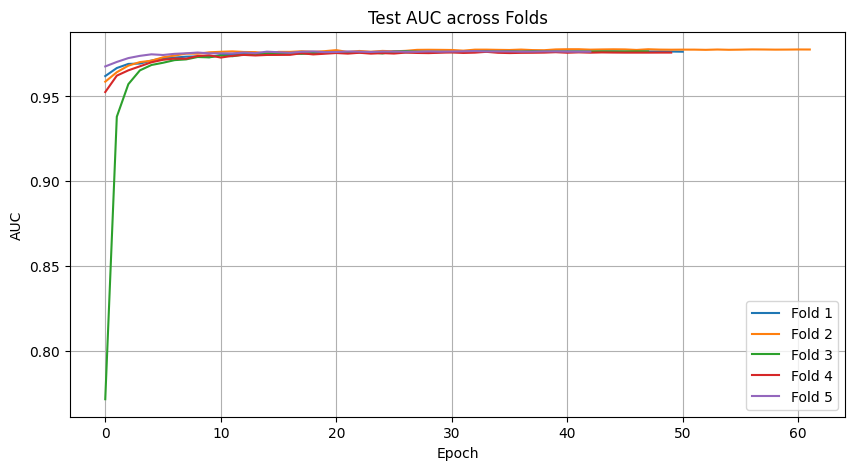



Average Metrics Across All Folds:
Roc_auc: 0.9769 ± 0.0005
Aupr: 0.9769 ± 0.0010
Mcc: 0.8556 ± 0.0031
Accuracy: 0.9278 ± 0.0016
Recall: 0.9314 ± 0.0023
Precision: 0.9251 ± 0.0030
F1: 0.9282 ± 0.0016
Specificity: 0.9242 ± 0.0033


In [ ]:
plot_metric_across_folds(all_train_losses, 'Train Loss across Folds', 'Loss')
plot_metric_across_folds(all_val_losses, 'Validation Loss across Folds', 'Loss')
plot_metric_across_folds(all_test_losses, 'Test Loss across Folds', 'Loss')

plot_metric_across_folds(all_train_aucs, 'Train AUC across Folds', 'AUC')
plot_metric_across_folds(all_val_aucs, 'Validation AUC across Folds', 'AUC')
plot_metric_across_folds(all_test_aucs, 'Test AUC across Folds', 'AUC')


print("\n\nAverage Metrics Across All Folds:")
for metric in metrics:
    mean = np.mean(metrics[metric])
    std = np.std(metrics[metric])
    print(f"{metric.capitalize()}: {mean:.4f} ± {std:.4f}")

###Concatenation of HLA and peptide embeddings

In [ ]:
metrics = {
    'roc_auc': [],
    'aupr': [],
    'mcc': [],
    'accuracy': [],
    'recall': [],
    'precision': [],
    'f1': [],
    'Specificity':[]
}



def create_model():

    def swish(x):
        return x * tf.nn.sigmoid(x)

    dropout_rate = 0.2
    ac = swish

    input_pep = Input(shape=(320,), name='peptide')
    x_pep = layers.Dense(256, activation=ac)(input_pep)
    x_pep = layers.BatchNormalization()(x_pep)
    x_pep = layers.Dropout(dropout_rate)(x_pep)
    x_pep = layers.Dense(128, activation=ac)(x_pep)
    x_pep = layers.BatchNormalization()(x_pep)
    x_pep = layers.Dropout(dropout_rate)(x_pep)
    x_pep = layers.Dense(64, activation=ac)(x_pep)
    x_pep = layers.BatchNormalization()(x_pep)
    x_pep = layers.Dropout(dropout_rate)(x_pep)

    input_hla = Input(shape=(320,), name='hla')
    x_hla = layers.Dense(256, activation=ac)(input_hla)
    x_hla = layers.BatchNormalization()(x_hla)
    x_hla = layers.Dropout(dropout_rate)(x_hla)
    x_hla = layers.Dense(128, activation=ac)(x_hla)
    x_hla = layers.BatchNormalization()(x_hla)
    x_hla = layers.Dropout(dropout_rate)(x_hla)
    x_hla = layers.Dense(64, activation=ac)(x_hla)
    x_hla = layers.BatchNormalization()(x_hla)
    x_hla = layers.Dropout(dropout_rate)(x_hla)

    x = layers.Concatenate()([x_pep, x_hla])

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(16, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(8, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(1, activation=ac)(x)


    input_scores = Input(shape=(9,), name='scores')
    x = layers.Concatenate()([x, input_scores])
    x= layers.BatchNormalization()(x)
    x= layers.Dropout(dropout_rate)(x)
    output = layers.Dense(1, activation='sigmoid')(x)


    model = Model(inputs=[input_pep, input_hla, input_scores], outputs=output)

    optimizer = Adam(learning_rate=1e-3)
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='AUC'),
                 tf.keras.metrics.Recall(name='Recall'),
                 tf.keras.metrics.Precision(name='Precision'),
                 tf.keras.metrics.AUC(name='AUPR', curve='PR')]
    )
    return model

In [ ]:
all_train_losses = []
all_val_losses = []
all_test_losses = []

all_train_aucs = []
all_val_aucs = []
all_test_aucs = []


for fold in range(1, 6):
    print(f"\nFold {fold}/5")
    train_df = pd.read_csv(f"{save_dir}train_fold_{fold}.csv").drop(columns=['Unnamed: 0'])
    val_df = pd.read_csv(f"{save_dir}val_fold_{fold}.csv").drop(columns=['Unnamed: 0'])
    test_df = pd.read_csv(f"{save_dir}test_fold_{fold}.csv").drop(columns=['Unnamed: 0'])

    X_train = train_df.drop(columns=['label', 'HLA', 'peptide'])
    y_train = train_df['label']
    X_val = val_df.drop(columns=['label', 'HLA', 'peptide'])
    y_val = val_df['label']
    X_test = test_df.drop(columns=['label', 'HLA', 'peptide'])
    y_test = test_df['label']


    inputs_train = {
        'peptide': X_train.iloc[:, 9:329].values,
        'hla': X_train.iloc[:, 329:].values,
        'scores': X_train.iloc[:, :9].values
    }
    inputs_val = {
        'peptide': X_val.iloc[:, 9:329].values,
        'hla': X_val.iloc[:, 329:].values,
        'scores': X_val.iloc[:, :9].values
    }
    inputs_test = {
        'peptide': X_test.iloc[:, 9:329].values,
        'hla': X_test.iloc[:, 329:].values,
        'scores': X_test.iloc[:, :9].values
    }

    test_eval_callback = TestEvaluationCallback((inputs_test, y_test))

    model = create_model()
    history = model.fit(
        x=inputs_train,
        y=y_train,
        validation_data=(inputs_val, y_val),
        batch_size=256,
        epochs=100,
        verbose=0,
        callbacks=[
            test_eval_callback,
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
        ]
    )


    all_train_losses.append(history.history['loss'])
    all_val_losses.append(history.history['val_loss'])
    all_test_losses.append(test_eval_callback.epoch_metrics['loss'])
    all_train_aucs.append(history.history['AUC'])
    all_val_aucs.append(history.history['val_AUC'])
    all_test_aucs.append(test_eval_callback.epoch_metrics['AUC'])


    y_pred_proba = model.predict(inputs_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    metrics['roc_auc'].append(roc_auc_score(y_test, y_pred_proba))
    metrics['aupr'].append(average_precision_score(y_test, y_pred_proba))
    metrics['mcc'].append(matthews_corrcoef(y_test, y_pred))
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['recall'].append(recall_score(y_test, y_pred))
    metrics['precision'].append(precision_score(y_test, y_pred))
    metrics['f1'].append(f1_score(y_test, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    metrics['Specificity'].append(specificity)

    print(f"\nMetrics for Fold {fold}:")
    print(f"ROC AUC: {metrics['roc_auc'][-1]:.4f}")
    print(f"AUPR: {metrics['aupr'][-1]:.4f}")
    print(f"MCC: {metrics['mcc'][-1]:.4f}")
    print(f"Accuracy: {metrics['accuracy'][-1]:.4f}")
    print(f"Recall: {metrics['recall'][-1]:.4f}")
    print(f"Precision: {metrics['precision'][-1]:.4f}")
    print(f"F1 Score: {metrics['f1'][-1]:.4f}")
    print(f"Specificity: {metrics['Specificity'][-1]:.4f}")


Fold 1/5

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 44: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 49: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 49: early stopping
Restoring model weights from the end of the best epoch: 39.
775/775 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

Metrics for Fold 1:
ROC AUC: 0.9760
AUPR: 0.9770
MCC: 0.8508
Accuracy: 0.9254
Recall: 0.9280
Precision: 0.9245
F1 Score: 0.9262
Specificity: 0.9227

Fold 2/5

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 48: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 38.
775/775 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

Metrics for Fold 2:
ROC AUC: 0.97

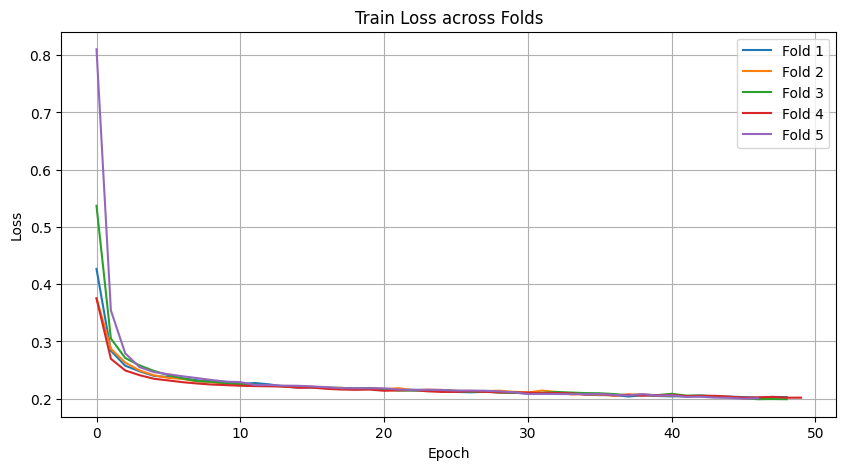

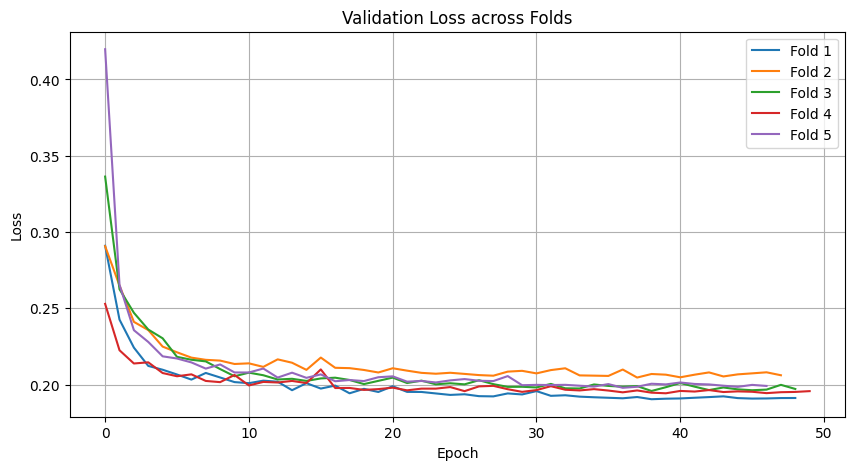

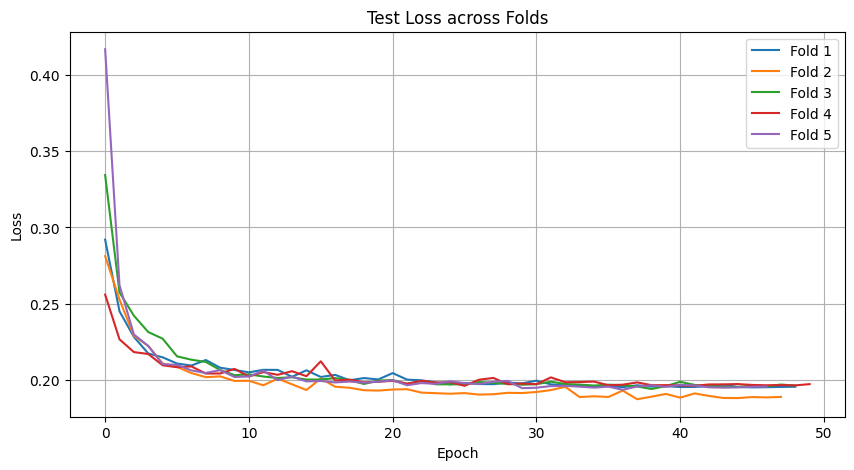

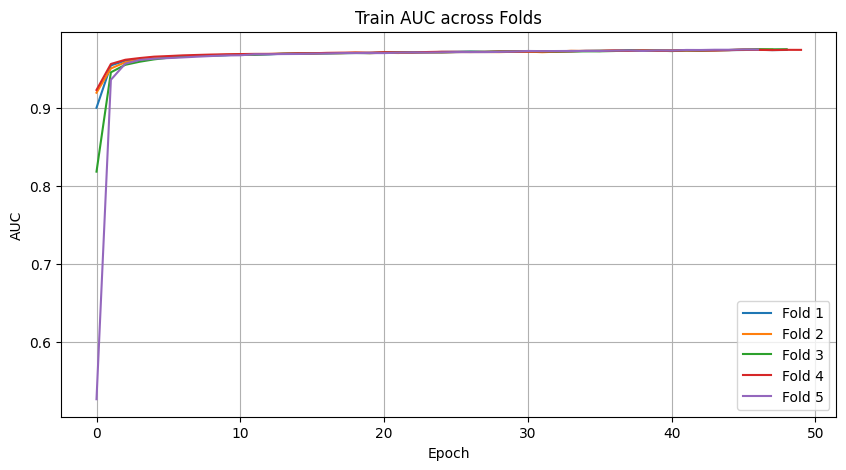

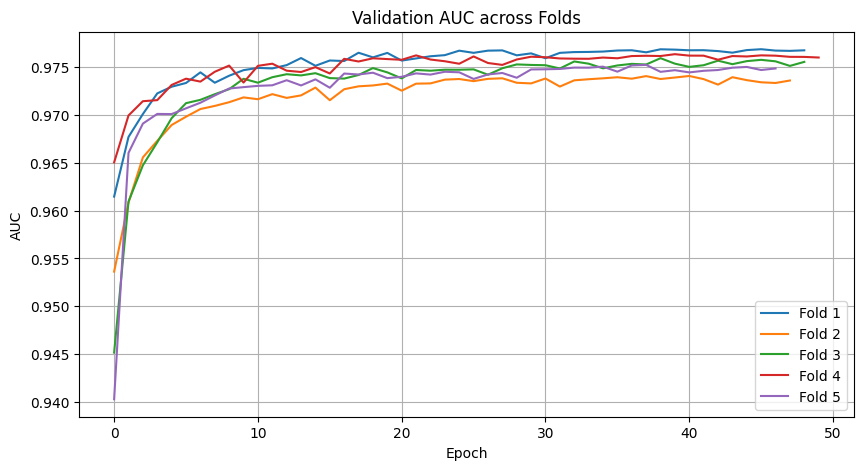

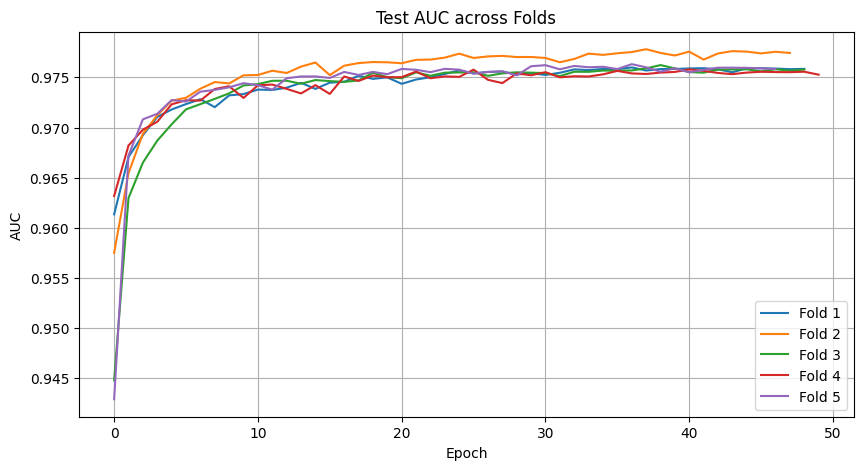



Average Metrics Across All Folds:
Roc_auc: 0.9764 ± 0.0008
Aupr: 0.9766 ± 0.0010
Mcc: 0.8541 ± 0.0041
Accuracy: 0.9270 ± 0.0020
Recall: 0.9297 ± 0.0025
Precision: 0.9251 ± 0.0034
F1: 0.9274 ± 0.0022
Specificity: 0.9243 ± 0.0034


In [ ]:
plot_metric_across_folds(all_train_losses, 'Train Loss across Folds', 'Loss')
plot_metric_across_folds(all_val_losses, 'Validation Loss across Folds', 'Loss')
plot_metric_across_folds(all_test_losses, 'Test Loss across Folds', 'Loss')

plot_metric_across_folds(all_train_aucs, 'Train AUC across Folds', 'AUC')
plot_metric_across_folds(all_val_aucs, 'Validation AUC across Folds', 'AUC')
plot_metric_across_folds(all_test_aucs, 'Test AUC across Folds', 'AUC')

print("\n\nAverage Metrics Across All Folds:")
for metric in metrics:
    mean = np.mean(metrics[metric])
    std = np.std(metrics[metric])
    print(f"{metric.capitalize()}: {mean:.4f} ± {std:.4f}")

### Absence of Consensus and NetMHCcons models


In [ ]:
metrics = {
    'roc_auc': [],
    'aupr': [],
    'mcc': [],
    'accuracy': [],
    'recall': [],
    'precision': [],
    'f1': [],
    'Specificity':[]
}


def create_model():
    def swish(x):
        return x * tf.nn.sigmoid(x)

    dropout_rate = 0.2
    ac = swish


    input_pep = Input(shape=(320,), name='peptide')
    x_pep = layers.Dense(256, activation=ac)(input_pep)
    x_pep = layers.BatchNormalization()(x_pep)
    x_pep = layers.Dropout(dropout_rate)(x_pep)
    x_pep = layers.Dense(128, activation=ac)(x_pep)
    x_pep = layers.BatchNormalization()(x_pep)
    x_pep = layers.Dropout(dropout_rate)(x_pep)
    x_pep = layers.Dense(64, activation=ac)(x_pep)


    input_hla = Input(shape=(320,), name='hla')
    x_hla = layers.Dense(256, activation=ac)(input_hla)
    x_hla = layers.BatchNormalization()(x_hla)
    x_hla = layers.Dropout(dropout_rate)(x_hla)
    x_hla = layers.Dense(128, activation=ac)(x_hla)
    x_hla = layers.BatchNormalization()(x_hla)
    x_hla = layers.Dropout(dropout_rate)(x_hla)
    x_hla = layers.Dense(64, activation=ac)(x_hla)


    x1 = layers.Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([x_hla, x_pep])
    x2 = layers.Multiply()([x_pep, x_hla])
    x = layers.Concatenate()([x1, x2])

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(16, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(8, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(1, activation=ac)(x)

    input_scores = Input(shape=(7,), name='scores')
    x = layers.Concatenate()([x, input_scores])
    x= layers.BatchNormalization()(x)
    x= layers.Dropout(dropout_rate)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_pep, input_hla, input_scores], outputs=output)

    try:
        from tensorflow.keras.optimizers.experimental import AdamW
        optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-4)
    except ImportError:
        from tensorflow.keras.optimizers import Adam
        optimizer = Adam(learning_rate=1e-3)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='AUC'),
                 tf.keras.metrics.Recall(name='Recall'),
                 tf.keras.metrics.Precision(name='Precision'),
                 tf.keras.metrics.AUC(name='AUPR', curve='PR')]
    )

    return model


Fold 1/5

Epoch 21: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 33: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 38: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 38: early stopping
Restoring model weights from the end of the best epoch: 28.


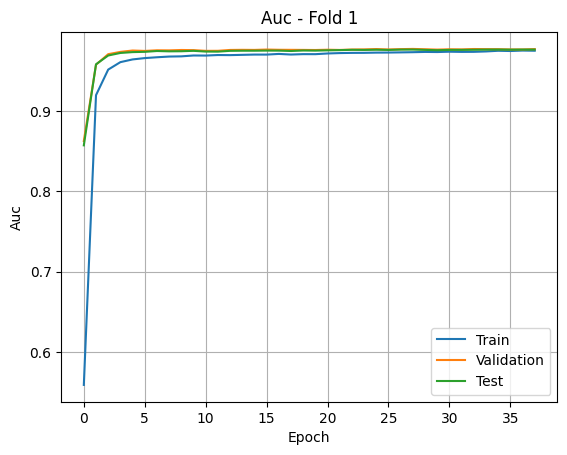

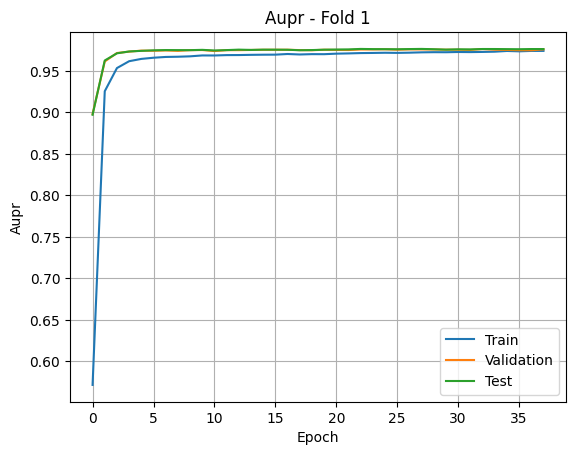

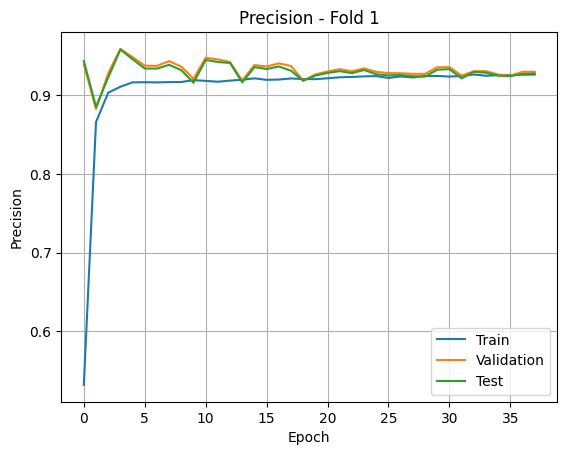

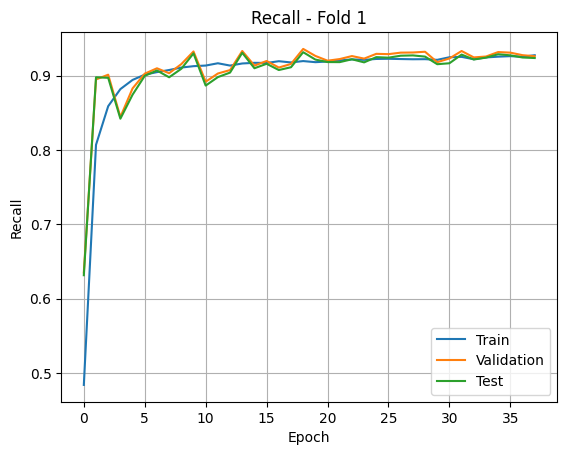

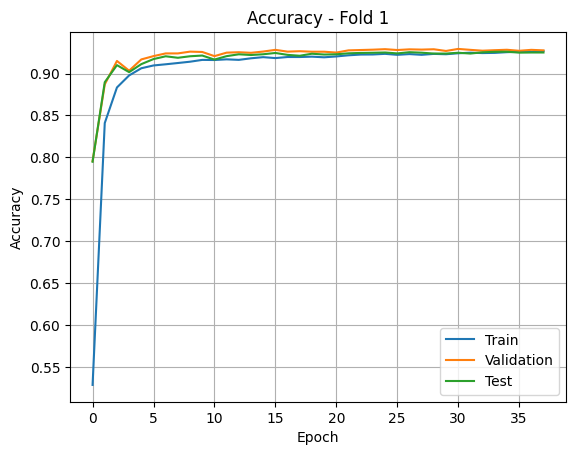

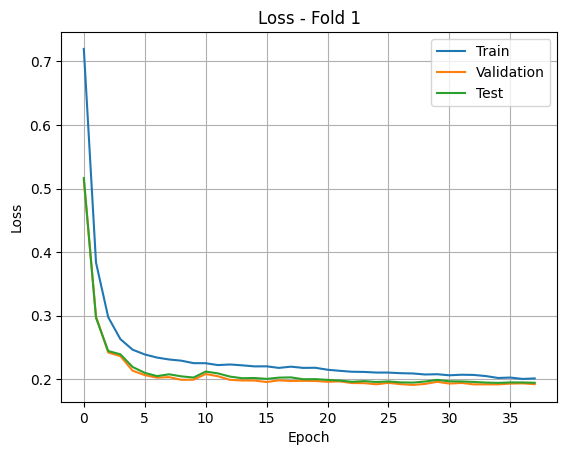

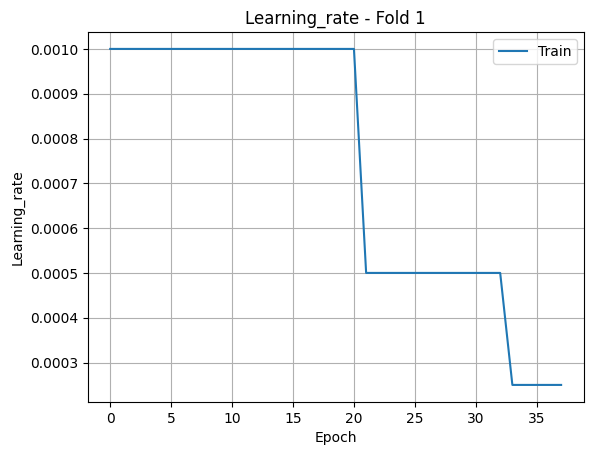

775/775 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

Metrics for Fold 1:
ROC AUC: 0.9763
AUPR: 0.9773
MCC: 0.8496
Accuracy: 0.9248
Recall: 0.9273
Precision: 0.9239
F1 Score: 0.9256
Specificity: 0.9222

Fold 2/5

Epoch 27: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 39: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 45: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 50: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 50: early stopping
Restoring model weights from the end of the best epoch: 40.


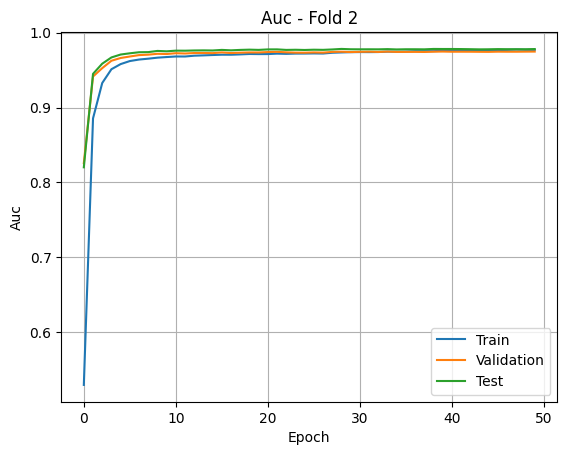

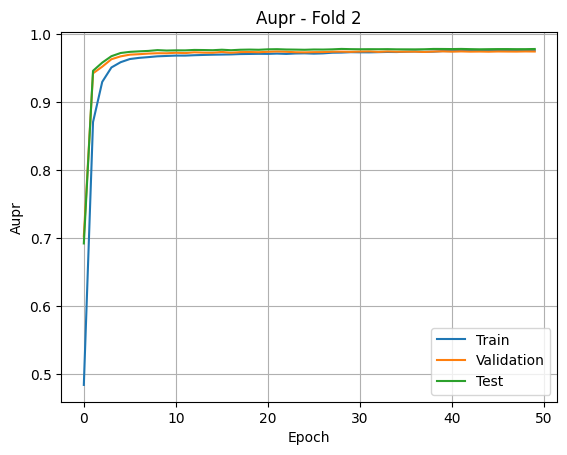

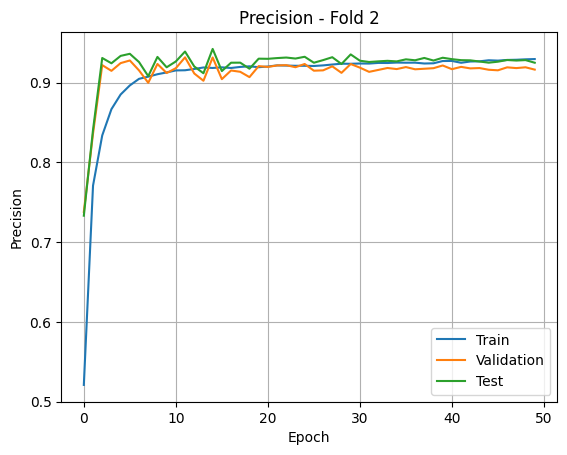

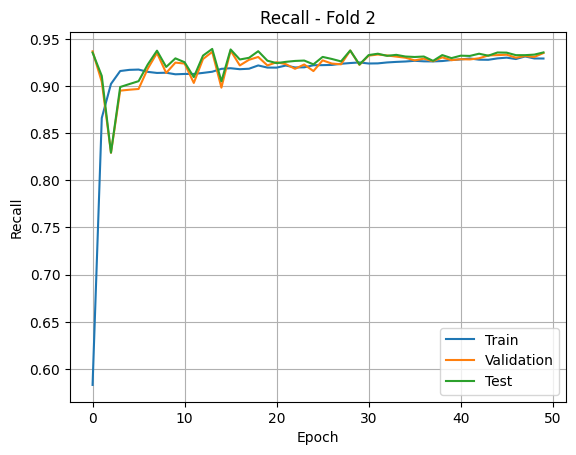

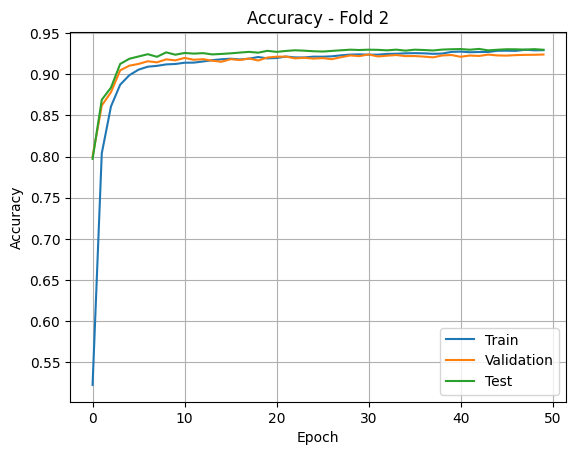

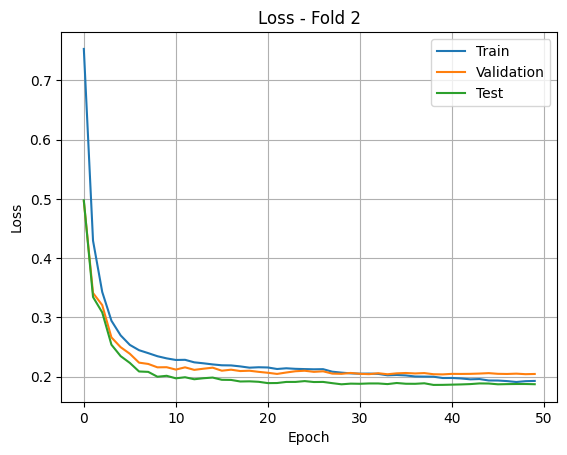

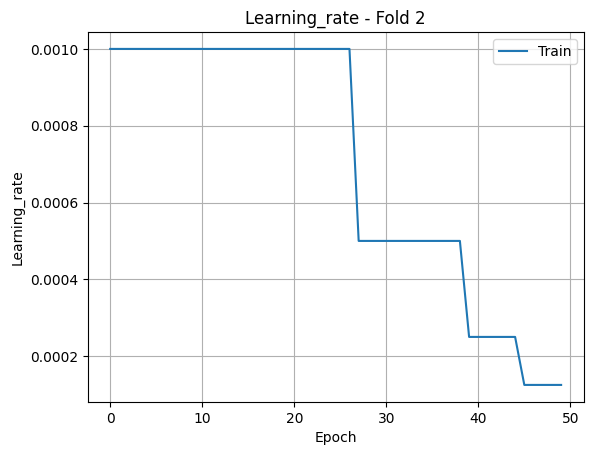

775/775 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step

Metrics for Fold 2:
ROC AUC: 0.9783
AUPR: 0.9786
MCC: 0.8607
Accuracy: 0.9304
Recall: 0.9295
Precision: 0.9312
F1 Score: 0.9304
Specificity: 0.9312

Fold 3/5

Epoch 20: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 30: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 43: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 48: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 38.


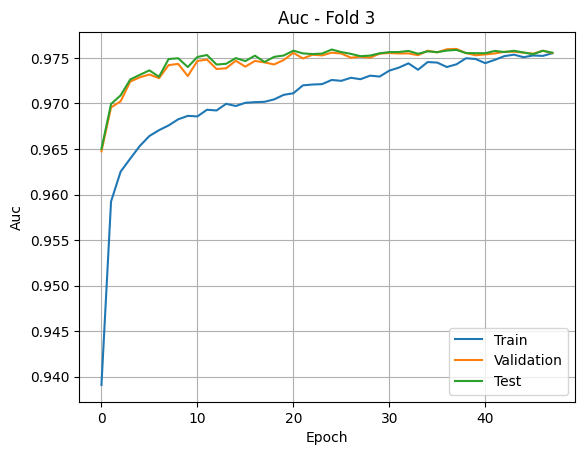

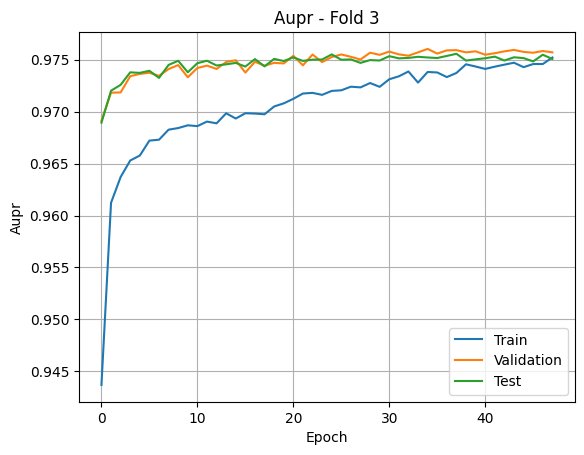

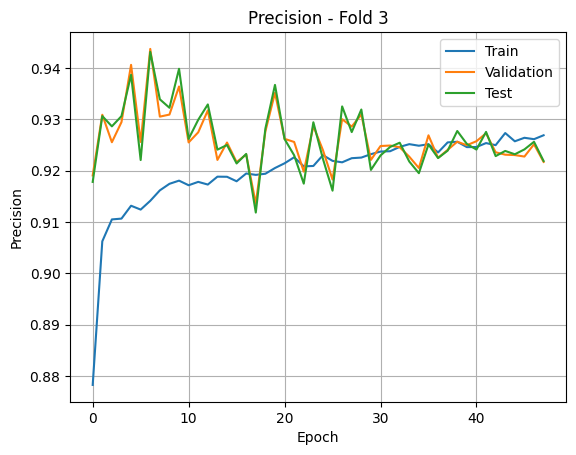

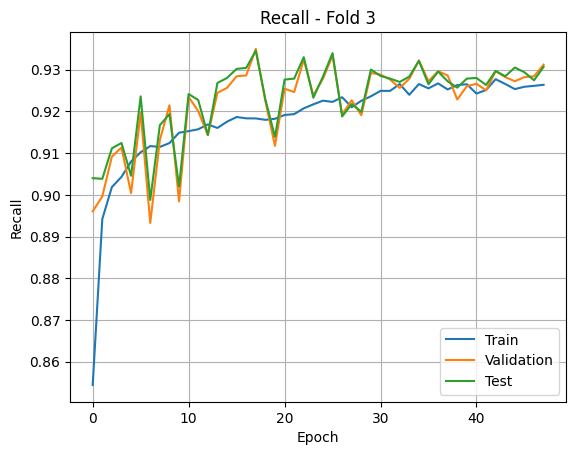

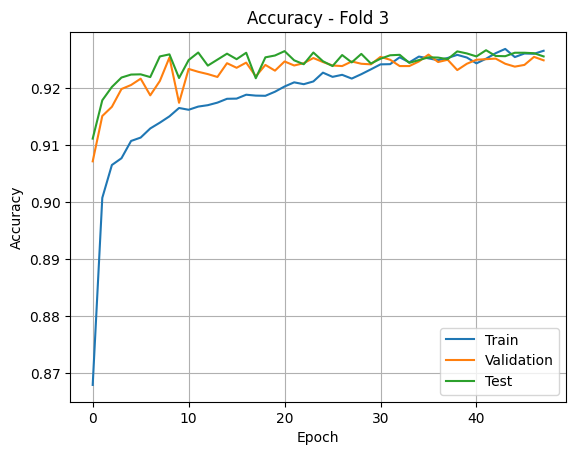

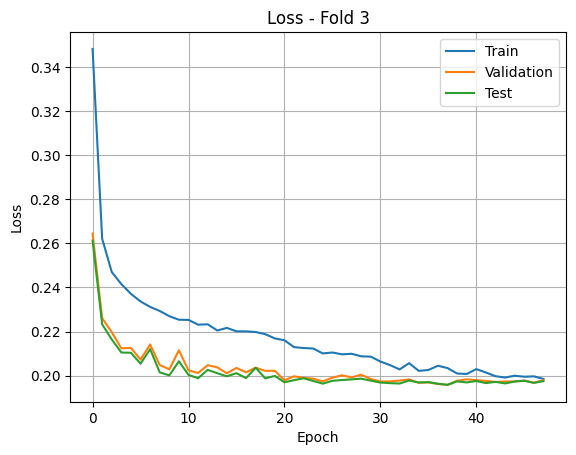

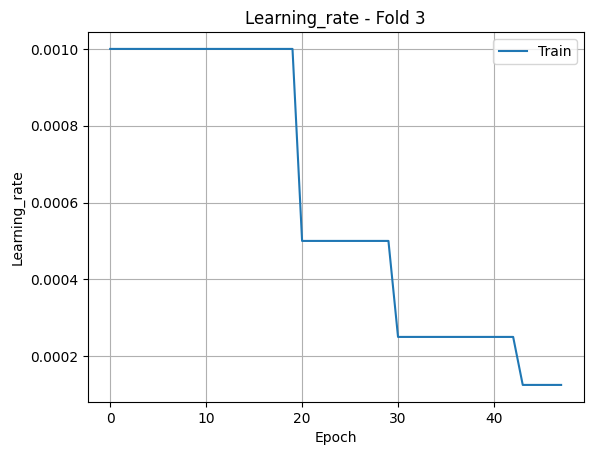

775/775 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step

Metrics for Fold 3:
ROC AUC: 0.9760
AUPR: 0.9761
MCC: 0.8503
Accuracy: 0.9251
Recall: 0.9272
Precision: 0.9239
F1 Score: 0.9256
Specificity: 0.9230

Fold 4/5

Epoch 24: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 32: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 43: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 48: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 48: early stopping
Restoring model weights from the end of the best epoch: 38.


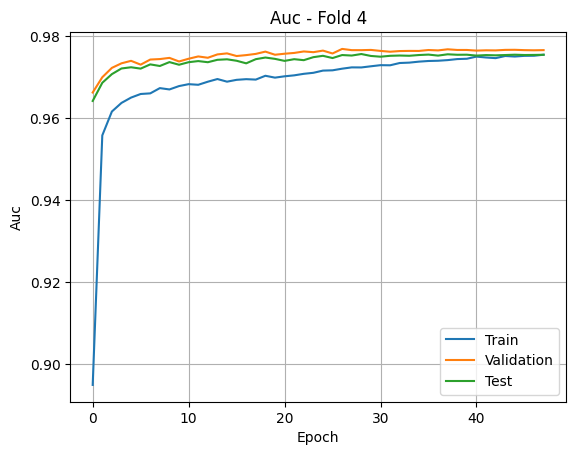

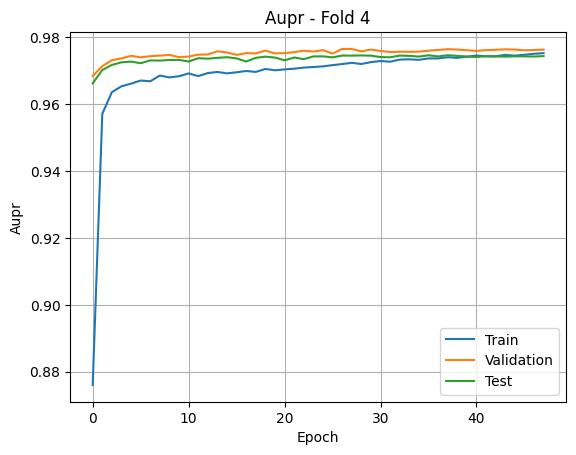

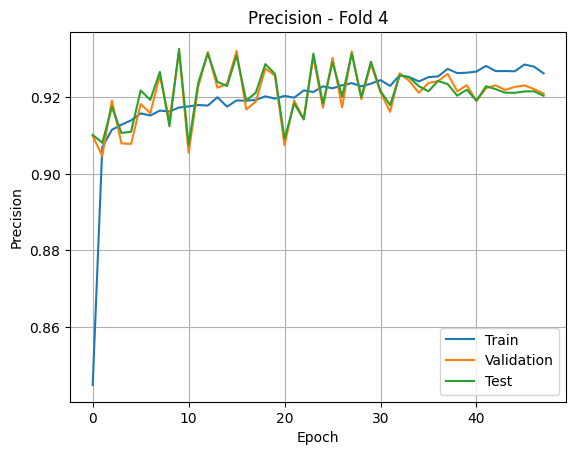

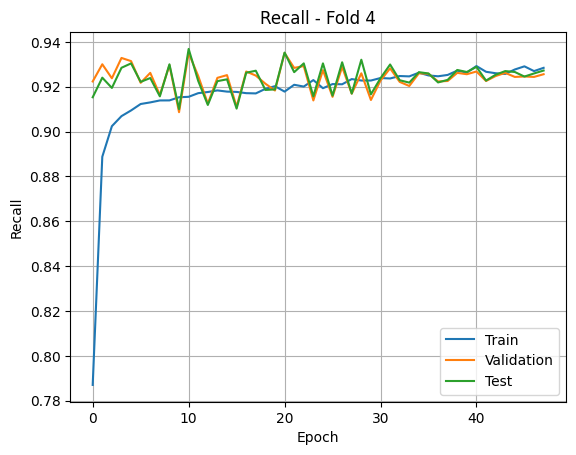

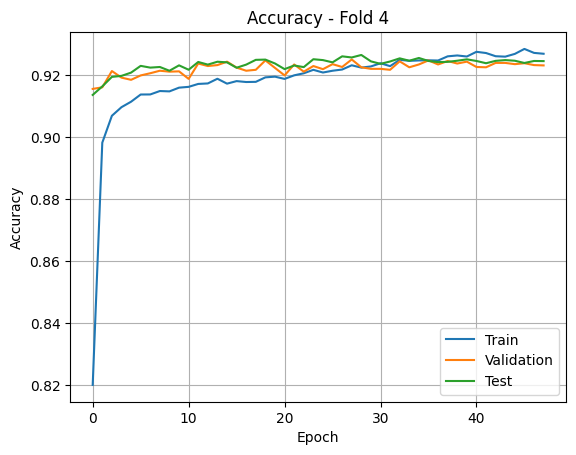

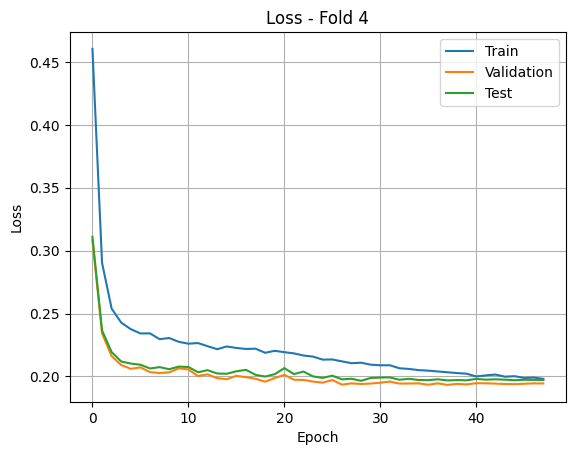

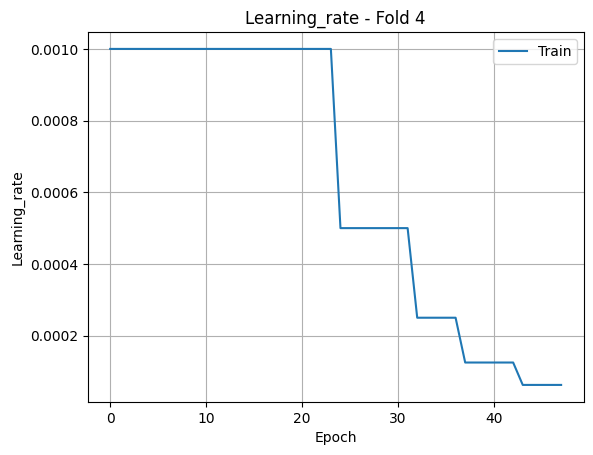

775/775 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

Metrics for Fold 4:
ROC AUC: 0.9758
AUPR: 0.9755
MCC: 0.8483
Accuracy: 0.9242
Recall: 0.9231
Precision: 0.9234
F1 Score: 0.9233
Specificity: 0.9253

Fold 5/5

Epoch 31: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 37: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 42: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

Epoch 48: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.

Epoch 53: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
Epoch 53: early stopping
Restoring model weights from the end of the best epoch: 43.


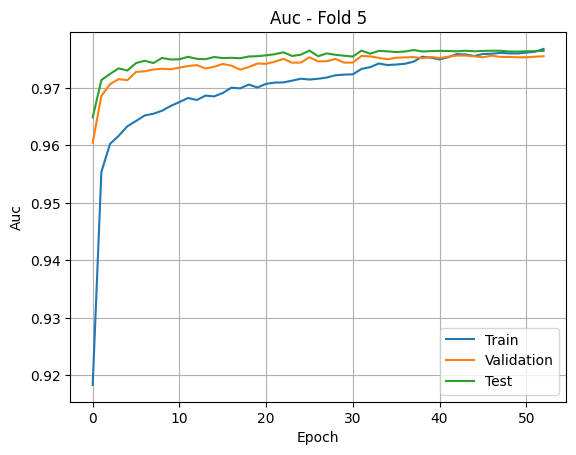

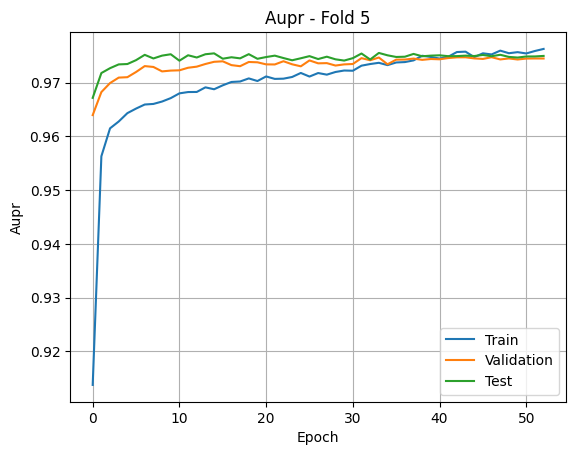

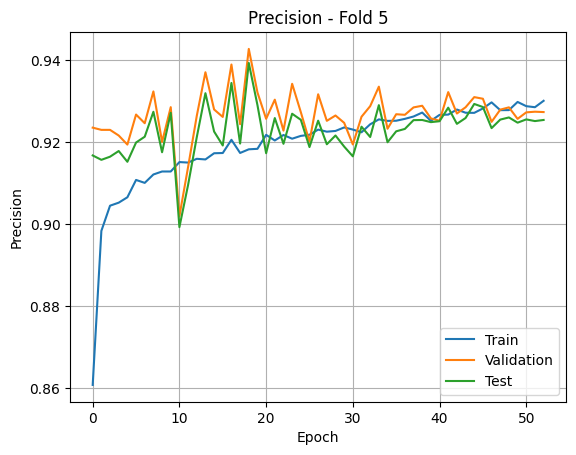

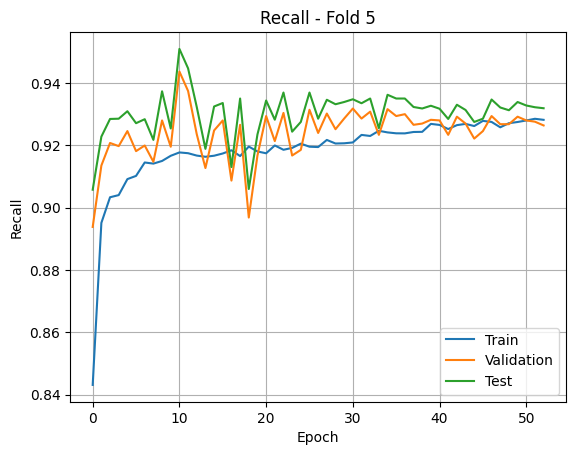

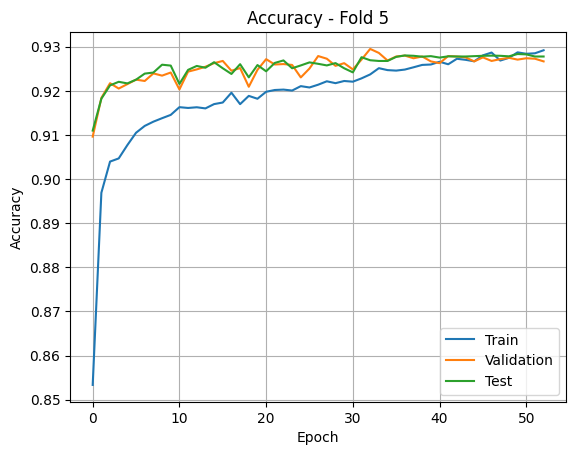

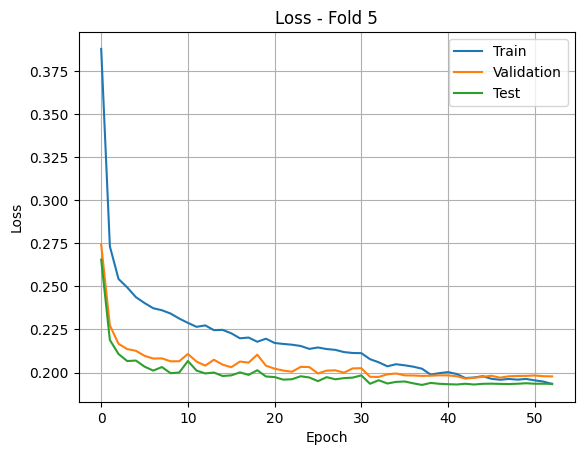

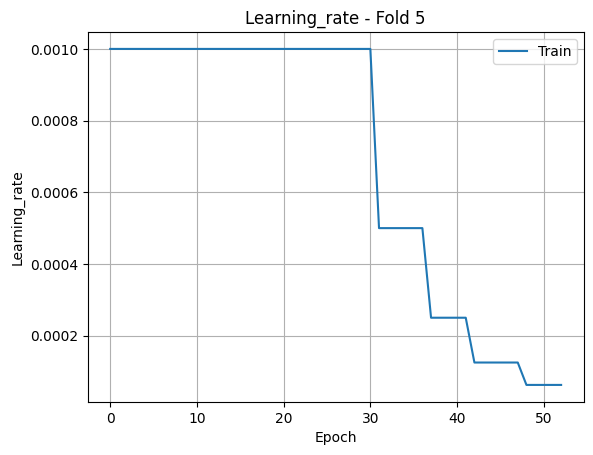

775/775 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step

Metrics for Fold 5:
ROC AUC: 0.9765
AUPR: 0.9759
MCC: 0.8555
Accuracy: 0.9278
Recall: 0.9330
Precision: 0.9245
F1 Score: 0.9287
Specificity: 0.9224


Average Metrics Across All Folds:
Roc_auc: 0.9766 ± 0.0009
Aupr: 0.9767 ± 0.0011
Mcc: 0.8529 ± 0.0046
Accuracy: 0.9264 ± 0.0023
Recall: 0.9280 ± 0.0033
Precision: 0.9254 ± 0.0029
F1: 0.9267 ± 0.0025
Specificity: 0.9248 ± 0.0034


In [ ]:
metrics = {
    'roc_auc': [],
    'aupr': [],
    'mcc': [],
    'accuracy': [],
    'recall': [],
    'precision': [],
    'f1': [],
    'Specificity':[]
}

for fold in range(1, 6):
    print(f"\nFold {fold}/5")
    train_df = pd.read_csv(f"{save_dir}train_fold_{fold}.csv").drop(columns=['Unnamed: 0'])
    val_df = pd.read_csv(f"{save_dir}val_fold_{fold}.csv").drop(columns=['Unnamed: 0'])
    test_df = pd.read_csv(f"{save_dir}test_fold_{fold}.csv").drop(columns=['Unnamed: 0'])


    X_train = train_df.drop(columns=['label', 'HLA', 'peptide','consensus','netmhccons'])
    y_train = train_df['label']
    X_val = val_df.drop(columns=['label', 'HLA', 'peptide','consensus','netmhccons'])
    y_val = val_df['label']
    X_test = test_df.drop(columns=['label', 'HLA', 'peptide','consensus','netmhccons'])
    y_test = test_df['label']

    inputs_train = {
        'peptide': X_train.iloc[:, 7:327].values,
        'hla': X_train.iloc[:, 327:].values,
        'scores': X_train.iloc[:, :7].values
    }
    inputs_val = {
        'peptide': X_val.iloc[:, 7:327].values,
        'hla': X_val.iloc[:, 327:].values,
        'scores': X_val.iloc[:, :7].values
    }
    inputs_test = {
        'peptide': X_test.iloc[:, 7:327].values,
        'hla': X_test.iloc[:, 327:].values,
        'scores': X_test.iloc[:, :7].values
    }


    test_eval_callback = TestEvaluationCallback((inputs_test, y_test))

    model = create_model()
    history = model.fit(
        x=inputs_train,
        y=y_train,
        validation_data=(inputs_val, y_val),
        batch_size=254,
        epochs=100,
        verbose=0,
        callbacks=[
            test_eval_callback,
            ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
            EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
        ]
    )


    plot_all_metrics_together(history, test_eval_callback, fold)


    y_pred_proba = model.predict(inputs_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    metrics['roc_auc'].append(roc_auc_score(y_test, y_pred_proba))
    metrics['aupr'].append(average_precision_score(y_test, y_pred_proba))
    metrics['mcc'].append(matthews_corrcoef(y_test, y_pred))
    metrics['accuracy'].append(accuracy_score(y_test, y_pred))
    metrics['recall'].append(recall_score(y_test, y_pred))
    metrics['precision'].append(precision_score(y_test, y_pred))
    metrics['f1'].append(f1_score(y_test, y_pred))

    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    specificity = tn / (tn + fp)
    metrics['Specificity'].append(specificity)

    print(f"\nMetrics for Fold {fold}:")
    print(f"ROC AUC: {metrics['roc_auc'][-1]:.4f}")
    print(f"AUPR: {metrics['aupr'][-1]:.4f}")
    print(f"MCC: {metrics['mcc'][-1]:.4f}")
    print(f"Accuracy: {metrics['accuracy'][-1]:.4f}")
    print(f"Recall: {metrics['recall'][-1]:.4f}")
    print(f"Precision: {metrics['precision'][-1]:.4f}")
    print(f"F1 Score: {metrics['f1'][-1]:.4f}")
    print(f"Specificity: {metrics['Specificity'][-1]:.4f}")


print("\n\nAverage Metrics Across All Folds:")
for metric in metrics:
    mean = np.mean(metrics[metric])
    std = np.std(metrics[metric])
    print(f"{metric.capitalize()}: {mean:.4f} ± {std:.4f}")


#Train ***SiaScoreNet*** on D1 and test on D2

In [ ]:
save_dir = 'Data/'

In [ ]:
df = pd.read_csv(save_dir+'D1 Dataset.csv')

In [ ]:
train_df, val_df = train_test_split(
    df,
    test_size=0.1,
    shuffle=True,
    stratify=df['label'],
    random_state=42
)

In [ ]:
y_val = val_df['label']
X_val = val_df.drop(['label','HLA','peptide'], axis=1)

In [ ]:
y_train = train_df['label']
X_train = train_df.drop(['label','HLA','peptide'], axis=1)

y_val = val_df['label']
X_val = val_df.drop(['label','HLA','peptide'], axis=1)


X_train_ens, X_val_ens = X_train.iloc[:,:9].values,  X_val.iloc[:,:9].values
X_train_peptide, X_val_peptide = X_train.iloc[:,9:329].values, X_val.iloc[:,9:329].values
X_train_mhc, X_val_mhc = X_train.iloc[:,329:].values, X_val.iloc[:,329:].values

In [ ]:
metrics = {
    'roc_auc': [],
    'aupr': [],
    'mcc': [],
    'accuracy': [],
    'recall': [],
    'precision': [],
    'f1': [],
    'Specificity':[]
}


def SiaScoreNet():
    def swish(x):
        return x * tf.nn.sigmoid(x)

    dropout_rate = 0.2
    ac = swish

    input_pep = Input(shape=(320,), name='peptide')
    x_pep = layers.Dense(256, activation=ac)(input_pep)
    x_pep = layers.BatchNormalization()(x_pep)
    x_pep = layers.Dropout(dropout_rate)(x_pep)
    x_pep = layers.Dense(128, activation=ac)(x_pep)
    x_pep = layers.BatchNormalization()(x_pep)
    x_pep = layers.Dropout(dropout_rate)(x_pep)
    x_pep = layers.Dense(64, activation=ac)(x_pep)

    input_hla = Input(shape=(320,), name='hla')
    x_hla = layers.Dense(256, activation=ac)(input_hla)
    x_hla = layers.BatchNormalization()(x_hla)
    x_hla = layers.Dropout(dropout_rate)(x_hla)
    x_hla = layers.Dense(128, activation=ac)(x_hla)
    x_hla = layers.BatchNormalization()(x_hla)
    x_hla = layers.Dropout(dropout_rate)(x_hla)
    x_hla = layers.Dense(64, activation=ac)(x_hla)

    x1 = layers.Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([x_hla, x_pep])
    x2 = layers.Multiply()([x_pep, x_hla])
    x = layers.Concatenate()([x1, x2])

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(16, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(8, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(1, activation=ac)(x)

    input_scores = Input(shape=(9,), name='scores')
    x = layers.Concatenate()([x, input_scores])
    x= layers.BatchNormalization()(x)
    x= layers.Dropout(dropout_rate)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_pep, input_hla, input_scores], outputs=output)

    try:
        from tensorflow.keras.optimizers.experimental import AdamW
        optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-4)
    except ImportError:
        from tensorflow.keras.optimizers import Adam
        optimizer = Adam(learning_rate=1e-3)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='AUC'),
                 tf.keras.metrics.Recall(name='Recall'),
                 tf.keras.metrics.Precision(name='Precision'),
                 tf.keras.metrics.AUC(name='AUPR', curve='PR')]
    )

    return model

test_eval_callback = TestEvaluationCallback(([X_val_peptide, X_val_mhc, X_val_ens], y_val))
callbacks = [
    test_eval_callback,
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

In [ ]:
model = SiaScoreNet()

history = model.fit(
    x=[X_train_peptide, X_train_mhc, X_train_ens],
    y=y_train,
    validation_data=([X_val_peptide, X_val_mhc, X_val_ens], y_val),
    batch_size=256,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)


model.save(os.path.join(save_dir, "SiaScoreNet_trained_on_D1_model.h5"))

Epoch 1/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 37s 46ms/step - AUC: 0.7484 - AUPR: 0.7439 - Precision: 0.6776 - Recall: 0.7388 - accuracy: 0.6923 - loss: 0.6029 - val_AUC: 0.9534 - val_AUPR: 0.9397 - val_Precision: 0.8569 - val_Recall: 0.9461 - val_accuracy: 0.8938 - val_loss: 0.2850 - learning_rate: 0.0010
Epoch 2/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - AUC: 0.9464 - AUPR: 0.9357 - Precision: 0.8687 - Recall: 0.9275 - accuracy: 0.8935 - loss: 0.2949 - val_AUC: 0.9646 - val_AUPR: 0.9617 - val_Precision: 0.8854 - val_Recall: 0.9393 - val_accuracy: 0.9086 - val_loss: 0.2433 - learning_rate: 0.0010
Epoch 3/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - AUC: 0.9554 - AUPR: 0.9485 - Precision: 0.8840 - Recall: 0.9319 - accuracy: 0.9052 - loss: 0.2666 - val_AUC: 0.9686 - val_AUPR: 0.9659 - val_Precision: 0.9044 - val_Recall: 0.9306 - val_accuracy: 0.9159 - val_loss: 0.2315 - learning_rate: 0.0010
Epoch 4/100
436/436 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - AUC: 0.9592 - AUPR: 0.9541 - Precisio

In [ ]:
from tensorflow import keras
import tensorflow as tf

model1 = SiaScoreNet()
model1.load_weights(save_dir+'SiaScoreNet_trained_on_D1_model.h5')

y_pred_proba = model1.predict([X_etest_peptide, X_etest_mhc, X_etest_ens])
y_pred = (y_pred_proba > 0.5).astype(int)

3000/3000 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


In [ ]:
metrics = evaluate_model(y_etest, y_pred, y_pred_proba)
print_metrics(metrics)

ROC AUC: 0.9642
AUPR: 0.9661
MCC: 0.8032
Accuracy: 0.8999
Recall (Sensitivity): 0.8546
Precision: 0.9400
F1 Score: 0.8953
Specificity: 0.9454

Confusion Matrix:
[[45323  2620]
 [ 6984 41063]]

Classification Report:
              precision    recall  f1-score       support
0              0.866481  0.945352  0.904200  47943.000000
1              0.940022  0.854642  0.895301  48047.000000
accuracy       0.899948  0.899948  0.899948      0.899948
macro avg      0.903252  0.899997  0.899750  95990.000000
weighted avg   0.903291  0.899948  0.899746  95990.000000


#Peptide similarity filtering

In [ ]:
save_dir = 'Data/'

In [ ]:
df = pd.read_csv(save_dir+'D1 Dataset.csv')

In [ ]:
import numpy as np
import pandas as pd
import random
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import os

amino_acids = list('ARNDCQEGHILKMFPSTWYV')

blosum62_values = [
    [ 4,-1,-2,-2, 0,-1,-1, 0,-2,-1,-1,-1,-1,-2,-1, 1, 0,-3,-2, 0],
    [-1, 5, 0,-2,-3, 1, 0,-2, 0,-3,-2, 2,-1,-3,-2,-1,-1,-3,-2,-3],
    [-2, 0, 6, 1,-3, 0, 0, 0, 1,-3,-3, 0,-2,-3,-2, 1, 0,-4,-2,-3],
    [-2,-2, 1, 6,-3, 0, 2,-1,-1,-3,-4,-1,-3,-3,-1, 0,-1,-4,-3,-3],
    [ 0,-3,-3,-3, 9,-3,-4,-3,-3,-1,-1,-3,-1,-2,-3,-1,-1,-2,-2,-1],
    [-1, 1, 0, 0,-3, 5, 2,-2, 0,-3,-2, 1, 0,-3,-1, 0,-1,-2,-1,-2],
    [-1, 0, 0, 2,-4, 2, 5,-2, 0,-3,-3, 1,-2,-3,-1, 0,-1,-3,-2,-2],
    [ 0,-2, 0,-1,-3,-2,-2, 6,-2,-4,-4,-2,-3,-3,-2, 0,-2,-2,-3,-3],
    [-2, 0, 1,-1,-3, 0, 0,-2, 8,-3,-3,-1,-2,-1,-2,-1,-2,-2, 2,-3],
    [-1,-3,-3,-3,-1,-3,-3,-4,-3, 4, 2,-3, 1, 0,-3,-2,-1,-3,-1, 3],
    [-1,-2,-3,-4,-1,-2,-3,-4,-3, 2, 4,-2, 2, 0,-3,-2,-1,-2,-1, 1],
    [-1, 2, 0,-1,-3, 1, 1,-2,-1,-3,-2, 5,-1,-3,-1, 0,-1,-3,-2,-2],
    [-1,-1,-2,-3,-1, 0,-2,-3,-2, 1, 2,-1, 5, 0,-2,-1,-1,-1,-1, 1],
    [-2,-3,-3,-3,-2,-3,-3,-3,-1, 0, 0,-3, 0, 6,-4,-2,-2, 1, 3,-1],
    [-1,-2,-2,-1,-3,-1,-1,-2,-2,-3,-3,-1,-2,-4, 7,-1,-1,-4,-3,-2],
    [ 1,-1, 1, 0,-1, 0, 0, 0,-1,-2,-2, 0,-1,-2,-1, 4, 1,-3,-2,-2],
    [ 0,-1, 0,-1,-1,-1,-1,-2,-2,-1,-1,-1,-1,-2,-1, 1, 5,-2,-2, 0],
    [-3,-3,-4,-4,-2,-2,-3,-2,-2,-3,-2,-3,-1, 1,-4,-3,-2,11, 2,-3],
    [-2,-2,-2,-3,-2,-1,-2,-3, 2,-1,-1,-2,-1, 3,-3,-2,-2, 2, 7,-1],
    [ 0,-3,-3,-3,-1,-2,-2,-3,-3, 3, 1,-2, 1,-1,-2,-2, 0,-3,-1, 4]
]
blosum62_matrix = pd.DataFrame(blosum62_values, index=amino_acids, columns=amino_acids)

def blosum62_vector(seq, max_len=15):
    vec = []
    for i in range(max_len):
        if i < len(seq):
            aa = seq[i]
            if aa in amino_acids:
                vec.extend(blosum62_matrix.loc[aa].values)
            else:
                vec.extend([0] * len(amino_acids))  #unknown aa
        else:
            vec.extend([0] * len(amino_acids))  #padding
    return np.array(vec)


peptides = df['peptide'].tolist()
vectors = [blosum62_vector(p) for p in tqdm(peptides)]
vectors = np.array(vectors)

random.seed(42)
idx_base = random.sample(range(len(peptides)), 10)
base_vectors = vectors[idx_base]

similarity_matrix = cosine_similarity(base_vectors, vectors)
similarity_matrix_norm = similarity_matrix / similarity_matrix.max(axis=1, keepdims=True)

test_indices = set()
for row in similarity_matrix_norm:
    similar = np.where(row > 0.5)[0]
    test_indices.update(similar)

test_indices = list(test_indices)
train_indices = list(set(range(len(df))) - set(test_indices))

df_train = df.iloc[train_indices].reset_index(drop=True)
df_test = df.iloc[test_indices].reset_index(drop=True)


print(f"Train samples: {len(df_train)}")
print(f"Test samples: {len(df_test)}")


100%|██████████| 123908/123908 [00:46<00:00, 2682.97it/s]


Train samples: 91579
Test samples: 32329


In [ ]:
train_df, val_df = train_test_split(
    df_train,
    test_size=0.1,
    shuffle=True,
    stratify=df_train['label'],
    random_state=42
)

y_train = train_df['label']
X_train = train_df.drop(['label','HLA','peptide'], axis=1)

y_val = val_df['label']
X_val = val_df.drop(['label','HLA','peptide'], axis=1)


X_train_ens, X_val_ens = X_train.iloc[:,:9].values,  X_val.iloc[:,:9].values
X_train_peptide, X_val_peptide = X_train.iloc[:,9:329].values, X_val.iloc[:,9:329].values
X_train_mhc, X_val_mhc = X_train.iloc[:,329:].values, X_val.iloc[:,329:].values

In [ ]:
def SiaScoreNet():
    def swish(x):
        return x * tf.nn.sigmoid(x)

    dropout_rate = 0.2
    ac = swish
    input_pep = Input(shape=(320,), name='peptide')
    x_pep = layers.Dense(256, activation=ac)(input_pep)
    x_pep = layers.BatchNormalization()(x_pep)
    x_pep = layers.Dropout(dropout_rate)(x_pep)
    x_pep = layers.Dense(128, activation=ac)(x_pep)
    x_pep = layers.BatchNormalization()(x_pep)
    x_pep = layers.Dropout(dropout_rate)(x_pep)
    x_pep = layers.Dense(64, activation=ac)(x_pep)

    input_hla = Input(shape=(320,), name='hla')
    x_hla = layers.Dense(256, activation=ac)(input_hla)
    x_hla = layers.BatchNormalization()(x_hla)
    x_hla = layers.Dropout(dropout_rate)(x_hla)
    x_hla = layers.Dense(128, activation=ac)(x_hla)
    x_hla = layers.BatchNormalization()(x_hla)
    x_hla = layers.Dropout(dropout_rate)(x_hla)
    x_hla = layers.Dense(64, activation=ac)(x_hla)

    x1 = layers.Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([x_hla, x_pep])
    x2 = layers.Multiply()([x_pep, x_hla])
    x = layers.Concatenate()([x1, x2])

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(64, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(32, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(16, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(8, activation=ac)(x)

    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout_rate)(x)
    x = layers.Dense(1, activation=ac)(x)

    input_scores = Input(shape=(9,), name='scores')
    x = layers.Concatenate()([x, input_scores])
    x= layers.BatchNormalization()(x)
    x= layers.Dropout(dropout_rate)(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[input_pep, input_hla, input_scores], outputs=output)

    try:
        from tensorflow.keras.optimizers.experimental import AdamW
        optimizer = AdamW(learning_rate=1e-3, weight_decay=1e-4)
    except ImportError:
        from tensorflow.keras.optimizers import Adam
        optimizer = Adam(learning_rate=1e-3)

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.AUC(name='AUC'),
                 tf.keras.metrics.Recall(name='Recall'),
                 tf.keras.metrics.Precision(name='Precision'),
                 tf.keras.metrics.AUC(name='AUPR', curve='PR')]
    )

    return model

test_eval_callback = TestEvaluationCallback(([X_val_peptide, X_val_mhc, X_val_ens], y_val))
callbacks = [
    test_eval_callback,
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
]

In [ ]:
model = SiaScoreNet()
history = model.fit(
    x=[X_train_peptide, X_train_mhc, X_train_ens],
    y=y_train,
    validation_data=([X_val_peptide, X_val_mhc, X_val_ens], y_val),
    batch_size=256,
    epochs=100,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 33s 60ms/step - AUC: 0.8223 - AUPR: 0.7986 - Precision: 0.7325 - Recall: 0.7192 - accuracy: 0.7443 - loss: 0.5161 - val_AUC: 0.9529 - val_AUPR: 0.9511 - val_Precision: 0.8447 - val_Recall: 0.9128 - val_accuracy: 0.8805 - val_loss: 0.3071 - learning_rate: 0.0010
Epoch 2/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 19s 57ms/step - AUC: 0.9465 - AUPR: 0.9436 - Precision: 0.8766 - Recall: 0.8762 - accuracy: 0.8841 - loss: 0.3052 - val_AUC: 0.9638 - val_AUPR: 0.9608 - val_Precision: 0.8987 - val_Recall: 0.9060 - val_accuracy: 0.9082 - val_loss: 0.2479 - learning_rate: 0.0010
Epoch 3/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 20s 55ms/step - AUC: 0.9537 - AUPR: 0.9517 - Precision: 0.8879 - Recall: 0.8872 - accuracy: 0.8946 - loss: 0.2765 - val_AUC: 0.9671 - val_AUPR: 0.9642 - val_Precision: 0.9070 - val_Recall: 0.9053 - val_accuracy: 0.9122 - val_loss: 0.2322 - learning_rate: 0.0010
Epoch 4/100
322/322 ━━━━━━━━━━━━━━━━━━━━ 20s 53ms/step - AUC: 0.9596 - AUPR: 0.9581 - Preci

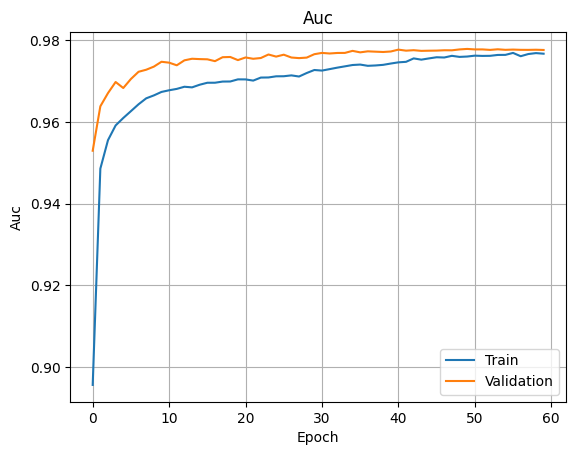

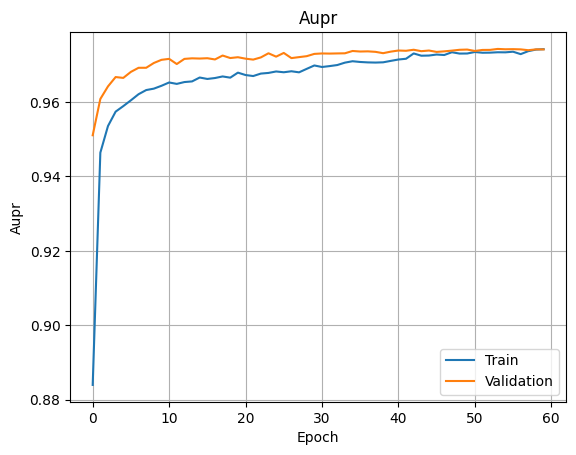

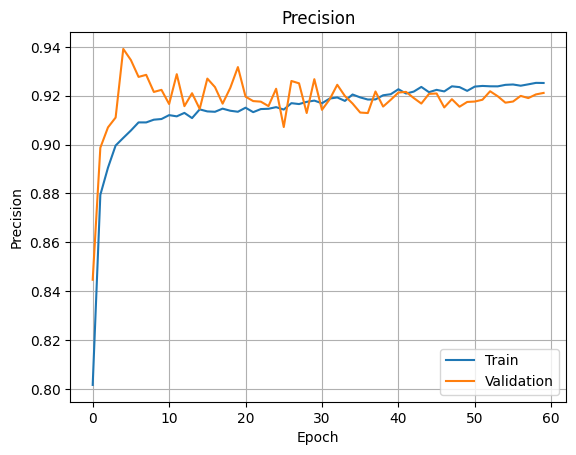

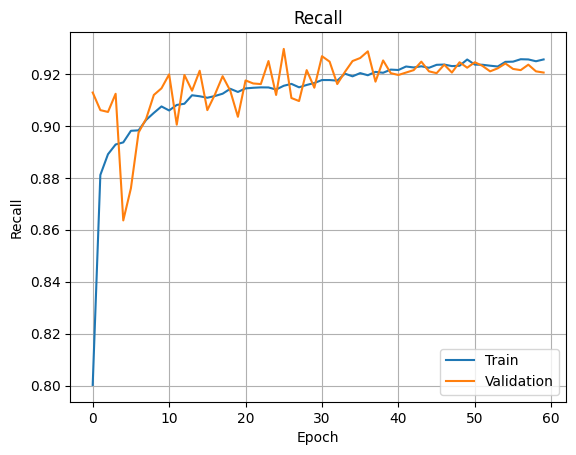

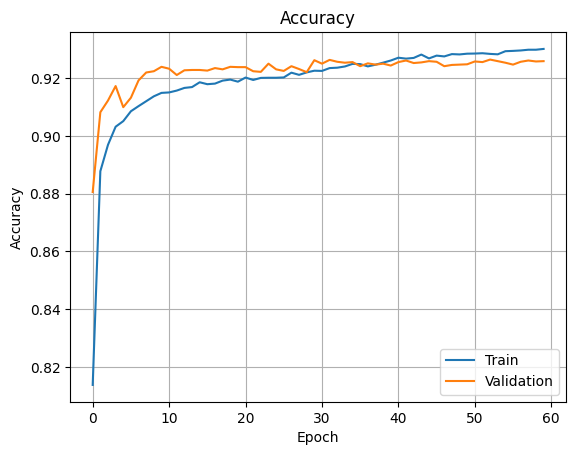

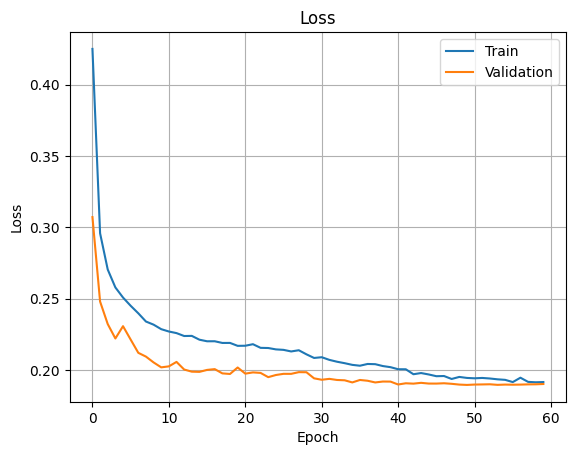

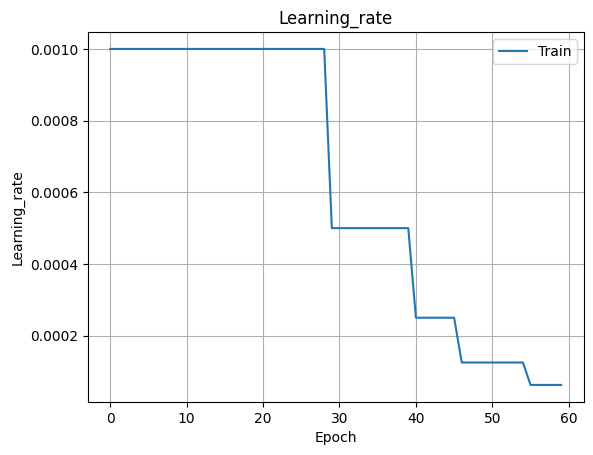

In [ ]:
plot_all_metrics_together(history, test_eval_callback)

In [ ]:
y_etest = df_test['label']
X_etest = df_test.drop(columns=["peptide","label","HLA"])
X_etest_ens = X_etest.iloc[:,:9].values
X_etest_peptide = X_etest.iloc[:,9:329].values
X_etest_mhc = X_etest.iloc[:,329:].values

In [ ]:
y_pred_proba = model.predict([X_etest_peptide, X_etest_mhc, X_etest_ens])
y_pred = (y_pred_proba > 0.5).astype(int)

1011/1011 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step


In [ ]:
metrics = evaluate_model(y_etest, y_pred, y_pred_proba)
print_metrics(metrics)

ROC AUC: 0.9776
AUPR: 0.9829
MCC: 0.8618
Accuracy: 0.9334
Recall (Sensitivity): 0.9471
Precision: 0.9413
F1 Score: 0.9442
Specificity: 0.9135

Confusion Matrix:
[[11982  1135]
 [ 1017 18195]]

Classification Report:
              precision    recall  f1-score       support
0              0.921763  0.913471  0.917598  13117.000000
1              0.941283  0.947064  0.944165  19212.000000
accuracy       0.933434  0.933434  0.933434      0.933434
macro avg      0.931523  0.930268  0.930882  32329.000000
weighted avg   0.933363  0.933434  0.933386  32329.000000
